![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.Clinical_Named_Entity_Recognition_Model.ipynb)

If you are using the `johnsnowlabs` library, please use this  [01.0.Clinical_Named_Entity_Recognition_Model](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/healthcare-nlp/01.0.Clinical_Named_Entity_Recognition_Model.ipynb) notebook.

# Clinical Named Entity Recognition (NER)

##  NER Model Implementation in Spark NLP

  The deep neural network architecture for NER model in Spark NLP is BiLSTM-CNN-Char framework. a slightly modified version of the architecture proposed by Jason PC Chiu and Eric Nichols ([Named Entity Recognition with Bidirectional LSTM-CNNs](https://arxiv.org/abs/1511.08308)). It is a neural network architecture that automatically detects word and character-level features using a hybrid bidirectional LSTM and CNN architecture, eliminating the need for most feature engineering steps.

  In the original framework, the CNN extracts a fixed length feature vector from character-level features. For each word, these vectors are concatenated and fed to the BLSTM network and then to the output layers. They employed a stacked bi-directional recurrent neural network with long short-term memory units to transform word features into named entity tag scores. The extracted features of each word are fed into a forward LSTM network and a backward LSTM network. The output of each network at each time step is decoded by a linear layer and a log-softmax layer into log-probabilities for each tag category. These two vectors are then simply added together to produce the final output. In the architecture of the proposed framework in the original paper, 50-dimensional pretrained word embeddings is used for word features, 25-dimension character embeddings is used for char features, and capitalization features (allCaps, upperInitial, lowercase, mixedCaps, noinfo) are used for case features.

## Blogposts and videos:

- [How to Setup Spark NLP for HEALTHCARE on UBUNTU - Video](https://www.youtube.com/watch?v=yKnF-_oz0GE)

- [Named Entity Recognition (NER) with BERT in Spark NLP](https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77)

- [State of the art Clinical Named Entity Recognition in Spark NLP - Youtube](https://www.youtube.com/watch?v=YM-e4eOiQ34)

- [Named Entity Recognition for Healthcare with SparkNLP NerDL and NerCRF](https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571)

- [Named Entity Recognition for Clinical Text](https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180)

## Healthcare NLP for Data Scientists Course

If you are not familiar with the components in this notebook, you can check [Healthcare NLP for Data Scientists Udemy Course](https://www.udemy.com/course/healthcare-nlp-for-data-scientists/) and the [MOOC Notebooks](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/Spark_NLP_Udemy_MOOC/Healthcare_NLP) for each components.

## Colab Setup

In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

In [2]:
license_keys.keys()

dict_keys(['SPARK_NLP_LICENSE', 'SECRET', 'JSL_VERSION', 'SPARK_OCR_LICENSE', 'SPARK_OCR_SECRET', 'OCR_VERSION', 'PUBLIC_VERSION', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'AWS_SESSION_TOKEN'])

In [3]:
license_keys['JSL_VERSION']

'6.1.1'

In [4]:
license_keys['PUBLIC_VERSION']

'6.1.3'

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.4.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [6]:
import json
import os

import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pipeline_tracer import PipelineTracer
from sparknlp_jsl.pipeline_output_parser import PipelineOutputParser

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 6.1.3
Spark NLP_JSL Version : 6.1.1


In [7]:
# if you want to start the session with custom params as in start function above
from pyspark.sql import SparkSession

def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")

    return builder.getOrCreate()

#spark = start(SECRET)


## Clinical NER Models


| index | model | index | model | index | model | index | model |
|------:|:------|------:|:------|------:|:------|------:|:------|
| 1 | [jsl_ner_wip_clinical](https://nlp.johnsnowlabs.com/2021/03/31/jsl_ner_wip_clinical_en.html) | 2 | [jsl_ner_wip_greedy_clinical](https://nlp.johnsnowlabs.com/2021/03/31/jsl_ner_wip_greedy_clinical_en.html) | 3 | [jsl_ner_wip_modifier_clinical](https://nlp.johnsnowlabs.com/2021/04/01/jsl_ner_wip_modifier_clinical_en.html) | 4 | [jsl_rd_ner_wip_greedy_clinical](https://nlp.johnsnowlabs.com/2021/04/01/jsl_rd_ner_wip_greedy_clinical_en.html) |
| 5 | [ner_abbreviation_clinical](https://nlp.johnsnowlabs.com/2021/12/30/ner_abbreviation_clinical_en.html) | 6 | [ner_abbreviation_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/05/12/ner_abbreviation_emb_clinical_large_en.html) | 7 | [ner_abbreviation_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/05/12/ner_abbreviation_emb_clinical_medium_en.html) | 8 | [ner_ade_clinical](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_clinical_en.html) |
| 9 | [ner_ade_clinical_langtest](https://nlp.johnsnowlabs.com/2023/07/31/ner_ade_clinical_langtest_en.html) | 10 | [ner_ade_clinical_v2](https://nlp.johnsnowlabs.com/2024/09/05/ner_ade_clinical_v2_en.html) | 11 | [ner_ade_clinicalbert](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_clinicalbert_en.html) | 12 | [ner_ade_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/05/21/ner_ade_emb_clinical_large_en.html) |
| 13 | [ner_ade_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/05/21/ner_ade_emb_clinical_medium_en.html) | 14 | [ner_ade_healthcare](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_healthcare_en.html) | 15 | [ner_alcohol_smoking](https://nlp.johnsnowlabs.com/2024/07/01/ner_alcohol_smoking_en.html) | 16 | [ner_anatomy](https://nlp.johnsnowlabs.com/2021/03/31/ner_anatomy_en.html) |
| 17 | [ner_anatomy_coarse](https://nlp.johnsnowlabs.com/2021/03/31/ner_anatomy_coarse_en.html) | 18 | [ner_anatomy_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/05/15/ner_anatomy_emb_clinical_large_en.html) | 19 | [ner_anatomy_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/05/15/ner_anatomy_emb_clinical_medium_en.html) | 20 | [ner_aspect_based_sentiment](https://nlp.johnsnowlabs.com/2021/03/31/ner_aspect_based_sentiment_en.html) |
| 21 | [ner_bacterial_species](https://nlp.johnsnowlabs.com/2021/04/01/ner_bacterial_species_en.html) | 22 | [ner_bacterial_species_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/05/23/ner_bacterial_species_emb_clinical_large_en.html) | 23 | [ner_bacterial_species_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/05/23/ner_bacterial_species_emb_clinical_medium_en.html) | 24 | [ner_bacterial_species_langtest](https://nlp.johnsnowlabs.com/2023/10/15/ner_bacterial_species_langtest_en.html) |
| 25 | [ner_biomarker](https://nlp.johnsnowlabs.com/2021/11/26/ner_biomarker_en.html) | 26 | [ner_biomarker_langtest](https://nlp.johnsnowlabs.com/2023/10/10/ner_biomarker_langtest_en.html) | 27 | [ner_biomedical_bc2gm](https://nlp.johnsnowlabs.com/2022/05/11/ner_biomedical_bc2gm_en_2_4.html) | 28 | [ner_bionlp](https://nlp.johnsnowlabs.com/2021/03/31/ner_bionlp_en.html) |
| 29 | [ner_bionlp_langtest](https://nlp.johnsnowlabs.com/2023/10/10/ner_bionlp_langtest_en.html) | 30 | [ner_cancer_genetics](https://nlp.johnsnowlabs.com/2021/03/31/ner_cancer_genetics_en.html) | 31 | [ner_cancer_types_wip](https://nlp.johnsnowlabs.com/2024/08/16/ner_cancer_types_wip_en.html) | 32 | [ner_cellular](https://nlp.johnsnowlabs.com/2021/03/31/ner_cellular_en.html) |
| 33 | [ner_cellular_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/05/24/ner_cellular_emb_clinical_large_en.html) | 34 | [ner_cellular_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/05/24/ner_cellular_emb_clinical_medium_en.html) | 35 | [ner_cellular_langtest](https://nlp.johnsnowlabs.com/2023/10/15/ner_cellular_langtest_en.html) | 36 | [ner_chemd_clinical](https://nlp.johnsnowlabs.com/2021/11/04/ner_chemd_clinical_en.html) |
| 37 | [ner_chemicals](https://nlp.johnsnowlabs.com/2021/04/01/ner_chemicals_en.html) | 38 | [ner_chemicals_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/06/02/ner_chemicals_emb_clinical_large_en.html) | 39 | [ner_chemicals_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/06/02/ner_chemicals_emb_clinical_medium_en.html) | 40 | [ner_chemprot_clinical](https://nlp.johnsnowlabs.com/2020/09/21/ner_chemprot_clinical_en.html) |
| 41 | [ner_chemprot_clinical_langtest](https://nlp.johnsnowlabs.com/2023/10/12/ner_chemprot_clinical_langtest_en.html) | 42 | [ner_chexpert](https://nlp.johnsnowlabs.com/2021/09/30/ner_chexpert_en.html) | 43 | [ner_clinical](https://nlp.johnsnowlabs.com/2021/03/31/ner_clinical_en.html) | 44 | [ner_clinical_abbreviation_langtest](https://nlp.johnsnowlabs.com/2024/01/25/ner_clinical_abbreviation_langtest_en.html) |
| 45 | [ner_clinical_langtest](https://nlp.johnsnowlabs.com/2023/09/26/ner_clinical_langtest_en.html) | 46 | [ner_clinical_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_clinical_large_en.html) | 47 | [ner_clinical_large_langtest](https://nlp.johnsnowlabs.com/2023/10/10/ner_clinical_large_langtest_en.html) | 48 | [ner_clinical_trials_abstracts](https://nlp.johnsnowlabs.com/2022/06/22/ner_clinical_trials_abstracts_en_3_0.html) |
| 49 | [ner_covid_trials](https://nlp.johnsnowlabs.com/2022/10/19/ner_covid_trials_en.html) | 50 | [ner_crf](https://nlp.johnsnowlabs.com/2020/01/28/ner_crf_en.html) | 51 | [ner_deid_aipii](https://nlp.johnsnowlabs.com/2024/09/25/ner_deid_aipii_en.html) | 52 | [ner_deid_enriched_langtest](https://nlp.johnsnowlabs.com/2023/10/15/ner_deid_enriched_langtest_en.html) |
| 53 | [ner_deid_generic_augmented_allUpperCased_langtest](https://nlp.johnsnowlabs.com/2023/10/16/ner_deid_generic_augmented_allUpperCased_langtest_en.html) | 54 | [ner_deid_generic_augmented_langtest](https://nlp.johnsnowlabs.com/2023/09/26/ner_deid_generic_augmented_langtest_en.html) | 55 | [ner_deid_generic_docwise](https://nlp.johnsnowlabs.com/2024/09/06/ner_deid_generic_docwise_en.html) | 56 | [ner_deid_large_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/04/12/ner_deid_large_emb_clinical_large_en.html) |
| 57 | [ner_deid_large_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/04/12/ner_deid_large_emb_clinical_medium_en.html) | 58 | [ner_deid_large_langtest](https://nlp.johnsnowlabs.com/2023/10/15/ner_deid_large_langtest_en.html) | 59 | [ner_deid_subentity_augmented](https://nlp.johnsnowlabs.com/2021/09/03/ner_deid_subentity_augmented_en.html) | 60 | [ner_deid_subentity_augmented_docwise](https://nlp.johnsnowlabs.com/2024/09/06/ner_deid_subentity_augmented_docwise_en.html) |
| 61 | [ner_deid_subentity_augmented_langtest](https://nlp.johnsnowlabs.com/2023/09/26/ner_deid_subentity_augmented_langtest_en.html) | 62 | [ner_deid_subentity_augmented_v2](https://nlp.johnsnowlabs.com/2024/09/20/ner_deid_subentity_augmented_v2_en.html) | 63 | [ner_deid_subentity_docwise](https://nlp.johnsnowlabs.com/2024/09/06/ner_deid_subentity_docwise_en.html) | 64 | [ner_demographic_extended_healthcare](https://nlp.johnsnowlabs.com/2023/06/08/ner_demographic_extended_healthcare_en.html) |
| 65 | [ner_diseases](https://nlp.johnsnowlabs.com/2021/03/31/ner_diseases_en.html) | 66 | [ner_diseases_langtest](https://nlp.johnsnowlabs.com/2023/10/15/ner_diseases_langtest_en.html) | 67 | [ner_diseases_large](https://nlp.johnsnowlabs.com/2021/04/01/ner_diseases_large_en.html) | 68 | [ner_drugprot_clinical](https://nlp.johnsnowlabs.com/2021/12/20/ner_drugprot_clinical_en.html) |
| 69 | [ner_drugs](https://nlp.johnsnowlabs.com/2021/03/31/ner_drugs_en.html) | 70 | [ner_drugs_greedy](https://nlp.johnsnowlabs.com/2021/03/31/ner_drugs_greedy_en.html) | 71 | [ner_drugs_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_drugs_large_en.html) | 72 | [ner_eu_clinical_case](https://nlp.johnsnowlabs.com/2023/01/25/ner_eu_clinical_case_en.html) |
| 73 | [ner_eu_clinical_condition](https://nlp.johnsnowlabs.com/2023/02/06/ner_eu_clinical_condition_en.html) | 74 | [ner_eu_clinical_condition_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_eu_clinical_condition_langtest_en.html) | 75 | [ner_events_admission_clinical](https://nlp.johnsnowlabs.com/2021/03/31/ner_events_admission_clinical_en.html) | 76 | [ner_events_clinical](https://nlp.johnsnowlabs.com/2021/03/31/ner_events_clinical_en.html) |
| 77 | [ner_events_clinical_langtest](https://nlp.johnsnowlabs.com/2023/08/31/ner_events_clinical_langtest_en.html) | 78 | [ner_events_healthcare](https://nlp.johnsnowlabs.com/2021/04/01/ner_events_healthcare_en.html) | 79 | [ner_financial_contract](https://nlp.johnsnowlabs.com/2021/04/01/ner_financial_contract_en.html) | 80 | [ner_genetic_variants](https://nlp.johnsnowlabs.com/2021/06/25/ner_genetic_variants_en.html) |
| 81 | [ner_healthcare](https://nlp.johnsnowlabs.com/2021/04/21/ner_healthcare_en.html) | 82 | [ner_human_phenotype_gene_clinical](https://nlp.johnsnowlabs.com/2020/09/21/ner_human_phenotype_gene_clinical_en.html) | 83 | [ner_human_phenotype_gene_clinical_langtest](https://nlp.johnsnowlabs.com/2023/11/04/ner_human_phenotype_gene_clinical_langtest_en.html) | 84 | [ner_human_phenotype_go_clinical](https://nlp.johnsnowlabs.com/2020/09/21/ner_human_phenotype_go_clinical_en.html) |
| 85 | [ner_human_phenotype_go_clinical_langtest](https://nlp.johnsnowlabs.com/2023/11/04/ner_human_phenotype_go_clinical_langtest_en.html) | 86 | [ner_jsl](https://nlp.johnsnowlabs.com/2022/10/19/ner_jsl_en.html) | 87 | [ner_jsl_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/04/12/ner_jsl_emb_clinical_large_en.html) | 88 | [ner_jsl_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/04/12/ner_jsl_emb_clinical_medium_en.html) |
| 89 | [ner_jsl_enriched](https://nlp.johnsnowlabs.com/2021/10/22/ner_jsl_enriched_en.html) | 90 | [ner_jsl_greedy](https://nlp.johnsnowlabs.com/2021/06/24/ner_jsl_greedy_en.html) | 91 | [ner_jsl_langtest](https://nlp.johnsnowlabs.com/2023/07/31/ner_jsl_langtest_en.html) | 92 | [ner_jsl_limited_80p_for_benchmarks](https://nlp.johnsnowlabs.com/2023/04/02/ner_jsl_limited_80p_for_benchmarks_en.html) |
| 93 | [ner_jsl_slim](https://nlp.johnsnowlabs.com/2021/08/13/ner_jsl_slim_en.html) | 94 | [ner_living_species](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_en_3_0.html) | 95 | [ner_living_species_langtest](https://nlp.johnsnowlabs.com/2023/10/10/ner_living_species_langtest_en.html) | 96 | [ner_measurements_clinical](https://nlp.johnsnowlabs.com/2021/04/01/ner_measurements_clinical_en.html) |
| 97 | [ner_medmentions_coarse](https://nlp.johnsnowlabs.com/2021/04/01/ner_medmentions_coarse_en.html) | 98 | [ner_menopause_core](https://nlp.johnsnowlabs.com/2024/07/03/ner_menopause_core_en.html) | 99 | [ner_nature_nero_clinical](https://nlp.johnsnowlabs.com/2022/02/08/ner_nature_nero_clinical_en.html) | 100 | [ner_nihss](https://nlp.johnsnowlabs.com/2021/11/15/ner_nihss_en.html) |
| 101 | [ner_oncology](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_en.html) | 102 | [ner_oncology_anatomy_general](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_anatomy_general_en.html) | 103 | [ner_oncology_anatomy_general_healthcare](https://nlp.johnsnowlabs.com/2023/01/11/ner_oncology_anatomy_general_healthcare_en.html) | 104 | [ner_oncology_anatomy_general_langtest](https://nlp.johnsnowlabs.com/2023/09/03/ner_oncology_anatomy_general_langtest_en.html) |
| 105 | [ner_oncology_anatomy_general_wip](https://nlp.johnsnowlabs.com/2022/09/30/ner_oncology_anatomy_general_wip_en.html) | 106 | [ner_oncology_anatomy_granular](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_anatomy_granular_en.html) | 107 | [ner_oncology_anatomy_granular_langtest](https://nlp.johnsnowlabs.com/2023/09/03/ner_oncology_anatomy_granular_langtest_en.html) | 108 | [ner_oncology_anatomy_granular_wip](https://nlp.johnsnowlabs.com/2022/10/01/ner_oncology_anatomy_granular_wip_en.html) |
| 109 | [ner_oncology_biomarker](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_biomarker_en.html) | 110 | [ner_oncology_biomarker_healthcare](https://nlp.johnsnowlabs.com/2023/01/11/ner_oncology_biomarker_healthcare_en.html) | 111 | [ner_oncology_biomarker_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_oncology_biomarker_langtest_en.html) | 112 | [ner_oncology_biomarker_wip](https://nlp.johnsnowlabs.com/2022/10/01/ner_oncology_biomarker_wip_en.html) |
| 113 | [ner_oncology_demographics](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_demographics_en.html) | 114 | [ner_oncology_demographics_langtest](https://nlp.johnsnowlabs.com/2023/09/03/ner_oncology_demographics_langtest_en.html) | 115 | [ner_oncology_demographics_wip](https://nlp.johnsnowlabs.com/2022/09/30/ner_oncology_demographics_wip_en.html) | 116 | [ner_oncology_diagnosis](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_diagnosis_en.html) |
| 117 | [ner_oncology_diagnosis_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_oncology_diagnosis_langtest_en.html) | 118 | [ner_oncology_diagnosis_wip](https://nlp.johnsnowlabs.com/2022/09/30/ner_oncology_diagnosis_wip_en.html) | 119 | [ner_oncology_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/04/12/ner_oncology_emb_clinical_large_en.html) | 120 | [ner_oncology_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/04/12/ner_oncology_emb_clinical_medium_en.html) |
| 121 | [ner_oncology_langtest](https://nlp.johnsnowlabs.com/2023/10/15/ner_oncology_langtest_en.html) | 122 | [ner_oncology_limited_80p_for_benchmarks](https://nlp.johnsnowlabs.com/2023/04/03/ner_oncology_limited_80p_for_benchmarks_en.html) | 123 | [ner_oncology_posology](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_posology_en.html) | 124 | [ner_oncology_posology_langtest](https://nlp.johnsnowlabs.com/2023/09/04/ner_oncology_posology_langtest_en.html) |
| 125 | [ner_oncology_posology_wip](https://nlp.johnsnowlabs.com/2022/10/01/ner_oncology_posology_wip_en.html) | 126 | [ner_oncology_response_to_treatment](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_response_to_treatment_en.html) | 127 | [ner_oncology_response_to_treatment_langtest](https://nlp.johnsnowlabs.com/2023/09/04/ner_oncology_response_to_treatment_langtest_en.html) | 128 | [ner_oncology_response_to_treatment_wip](https://nlp.johnsnowlabs.com/2022/10/01/ner_oncology_response_to_treatment_wip_en.html) |
| 129 | [ner_oncology_test](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_test_en.html) | 130 | [ner_oncology_test_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_oncology_test_langtest_en.html) | 131 | [ner_oncology_test_wip](https://nlp.johnsnowlabs.com/2022/09/30/ner_oncology_test_wip_en.html) | 132 | [ner_oncology_therapy](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_therapy_en.html) |
| 133 | [ner_oncology_therapy_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_oncology_therapy_langtest_en.html) | 134 | [ner_oncology_therapy_wip](https://nlp.johnsnowlabs.com/2022/09/30/ner_oncology_therapy_wip_en.html) | 135 | [ner_oncology_tnm](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_tnm_en.html) | 136 | [ner_oncology_tnm_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_oncology_tnm_langtest_en.html) |
| 137 | [ner_oncology_tnm_wip](https://nlp.johnsnowlabs.com/2022/09/30/ner_oncology_tnm_wip_en.html) | 138 | [ner_oncology_unspecific_posology](https://nlp.johnsnowlabs.com/2022/10/25/ner_oncology_unspecific_posology_en.html) | 139 | [ner_oncology_unspecific_posology_healthcare](https://nlp.johnsnowlabs.com/2023/01/11/ner_oncology_unspecific_posology_healthcare_en.html) | 140 | [ner_oncology_unspecific_posology_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_oncology_unspecific_posology_langtest_en.html) |
| 141 | [ner_oncology_unspecific_posology_wip](https://nlp.johnsnowlabs.com/2022/09/30/ner_oncology_unspecific_posology_wip_en.html) | 142 | [ner_oncology_wip](https://nlp.johnsnowlabs.com/2022/09/30/ner_oncology_wip_en.html) | 143 | [ner_opioid](https://nlp.johnsnowlabs.com/2024/03/27/ner_opioid_en.html) | 144 | [ner_opioid_small_wip](https://nlp.johnsnowlabs.com/2024/01/11/ner_opioid_small_wip_en.html) |
| 145 | [ner_pathogen](https://nlp.johnsnowlabs.com/2022/06/28/ner_pathogen_en_3_0.html) | 146 | [ner_posology](https://nlp.johnsnowlabs.com/2021/03/31/ner_posology_en.html) | 147 | [ner_posology_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/04/12/ner_posology_emb_clinical_large_en.html) | 148 | [ner_posology_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/04/12/ner_posology_emb_clinical_medium_en.html) |
| 149 | [ner_posology_experimental](https://nlp.johnsnowlabs.com/2021/09/01/ner_posology_experimental_en.html) | 150 | [ner_posology_greedy](https://nlp.johnsnowlabs.com/2021/03/31/ner_posology_greedy_en.html) | 151 | [ner_posology_healthcare](https://nlp.johnsnowlabs.com/2021/04/01/ner_posology_healthcare_en.html) | 152 | [ner_posology_langtest](https://nlp.johnsnowlabs.com/2023/07/28/ner_posology_langtest_en.html) |
| 153 | [ner_posology_large](https://nlp.johnsnowlabs.com/2021/03/31/ner_posology_large_en.html) | 154 | [ner_posology_small](https://nlp.johnsnowlabs.com/2021/03/31/ner_posology_small_en.html) | 155 | [ner_radiology](https://nlp.johnsnowlabs.com/2021/03/31/ner_radiology_en.html) | 156 | [ner_radiology_wip_clinical](https://nlp.johnsnowlabs.com/2021/04/01/ner_radiology_wip_clinical_en.html) |
| 157 | [ner_risk_factors](https://nlp.johnsnowlabs.com/2021/03/31/ner_risk_factors_en.html) | 158 | [ner_risk_factors_langtest](https://nlp.johnsnowlabs.com/2023/11/06/ner_risk_factors_langtest_en.html) | 159 | [ner_sdoh](https://nlp.johnsnowlabs.com/2023/06/13/ner_sdoh_en.html) | 160 | [ner_sdoh_access_to_healthcare](https://nlp.johnsnowlabs.com/2023/07/02/ner_sdoh_access_to_healthcare_en.html) |
| 161 | [ner_sdoh_access_to_healthcare_wip](https://nlp.johnsnowlabs.com/2024/06/10/ner_sdoh_access_to_healthcare_wip_en.html) | 162 | [ner_sdoh_community_condition](https://nlp.johnsnowlabs.com/2023/07/02/ner_sdoh_community_condition_en.html) | 163 | [ner_sdoh_community_condition_wip](https://nlp.johnsnowlabs.com/2024/06/10/ner_sdoh_community_condition_wip_en.html) | 164 | [ner_sdoh_core](https://nlp.johnsnowlabs.com/2024/04/08/ner_sdoh_core_en.html) |
| 165 | [ner_sdoh_demographics](https://nlp.johnsnowlabs.com/2023/07/02/ner_sdoh_demographics_en.html) | 166 | [ner_sdoh_demographics_wip](https://nlp.johnsnowlabs.com/2024/06/10/ner_sdoh_demographics_wip_en.html) | 167 | [ner_sdoh_emb_clinical_large_wip](https://nlp.johnsnowlabs.com/2023/04/17/ner_sdoh_emb_clinical_large_wip_en.html) | 168 | [ner_sdoh_emb_clinical_medium_wip](https://nlp.johnsnowlabs.com/2023/04/27/ner_sdoh_emb_clinical_medium_wip_en.html) |
| 169 | [ner_sdoh_health_behaviours_problems](https://nlp.johnsnowlabs.com/2023/07/02/ner_sdoh_health_behaviours_problems_en.html) | 170 | [ner_sdoh_health_behaviours_problems_wip](https://nlp.johnsnowlabs.com/2024/06/10/ner_sdoh_health_behaviours_problems_wip_en.html) | 171 | [ner_sdoh_income_social_status](https://nlp.johnsnowlabs.com/2023/07/02/ner_sdoh_income_social_status_en.html) | 172 | [ner_sdoh_income_social_status_wip](https://nlp.johnsnowlabs.com/2024/06/10/ner_sdoh_income_social_status_wip_en.html) |
| 173 | [ner_sdoh_langtest](https://nlp.johnsnowlabs.com/2023/07/31/ner_sdoh_langtest_en.html) | 174 | [ner_sdoh_mentions](https://nlp.johnsnowlabs.com/2022/12/18/ner_sdoh_mentions_en.html) | 175 | [ner_sdoh_slim_wip](https://nlp.johnsnowlabs.com/2022/11/15/ner_sdoh_slim_wip_en.html) | 176 | [ner_sdoh_social_environment](https://nlp.johnsnowlabs.com/2023/07/02/ner_sdoh_social_environment_en.html) |
| 177 | [ner_sdoh_social_environment_wip](https://nlp.johnsnowlabs.com/2024/06/10/ner_sdoh_social_environment_wip_en.html) | 178 | [ner_sdoh_substance_usage](https://nlp.johnsnowlabs.com/2023/07/02/ner_sdoh_substance_usage_en.html) | 179 | [ner_sdoh_substance_usage_wip](https://nlp.johnsnowlabs.com/2024/06/10/ner_sdoh_substance_usage_wip_en.html) | 180 | [ner_sdoh_wip](https://nlp.johnsnowlabs.com/2024/06/10/ner_sdoh_wip_en.html) |
| 181 | [ner_section_header_diagnosis](https://nlp.johnsnowlabs.com/2023/07/26/ner_section_header_diagnosis_en.html) | 182 | [ner_snomed_term](https://nlp.johnsnowlabs.com/2024/02/13/ner_snomed_term_en.html) | 183 | [ner_stigmatization_wip](https://nlp.johnsnowlabs.com/2024/08/27/ner_stigmatization_wip_en.html) | 184 | [ner_supplement_clinical](https://nlp.johnsnowlabs.com/2022/02/01/ner_supplement_clinical_en.html) |
| 185 | [ner_vop](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_en.html) | 186 | [ner_vop_anatomy](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_anatomy_en.html) | 187 | [ner_vop_anatomy_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_anatomy_emb_clinical_large_en.html) | 188 | [ner_vop_anatomy_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/06/07/ner_vop_anatomy_emb_clinical_medium_en.html) |
| 189 | [ner_vop_anatomy_langtest](https://nlp.johnsnowlabs.com/2023/09/21/ner_vop_anatomy_langtest_en.html) | 190 | [ner_vop_anatomy_wip](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_anatomy_wip_en.html) | 191 | [ner_vop_clinical_dept](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_clinical_dept_en.html) | 192 | [ner_vop_clinical_dept_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_clinical_dept_emb_clinical_large_en.html) |
| 193 | [ner_vop_clinical_dept_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_clinical_dept_emb_clinical_medium_en.html) | 194 | [ner_vop_clinical_dept_langtest](https://nlp.johnsnowlabs.com/2023/09/21/ner_vop_clinical_dept_langtest_en.html) | 195 | [ner_vop_clinical_dept_wip](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_clinical_dept_wip_en.html) | 196 | [ner_vop_demographic](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_demographic_en.html) |
| 197 | [ner_vop_demographic_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_demographic_emb_clinical_large_en.html) | 198 | [ner_vop_demographic_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_demographic_emb_clinical_medium_en.html) | 199 | [ner_vop_demographic_langtest](https://nlp.johnsnowlabs.com/2023/09/21/ner_vop_demographic_langtest_en.html) | 200 | [ner_vop_demographic_wip](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_demographic_wip_en.html) |
| 201 | [ner_vop_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_emb_clinical_large_en.html) | 202 | [ner_vop_emb_clinical_large_wip](https://nlp.johnsnowlabs.com/2023/04/12/ner_vop_emb_clinical_large_wip_en.html) | 203 | [ner_vop_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_emb_clinical_medium_en.html) | 204 | [ner_vop_emb_clinical_medium_wip](https://nlp.johnsnowlabs.com/2023/04/12/ner_vop_emb_clinical_medium_wip_en.html) |
| 205 | [ner_vop_langtest](https://nlp.johnsnowlabs.com/2023/10/10/ner_vop_langtest_en.html) | 206 | [ner_vop_problem](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_problem_en.html) | 207 | [ner_vop_problem_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_problem_emb_clinical_large_en.html) | 208 | [ner_vop_problem_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_problem_emb_clinical_medium_en.html) |
| 209 | [ner_vop_problem_langtest](https://nlp.johnsnowlabs.com/2023/09/21/ner_vop_problem_langtest_en.html) | 210 | [ner_vop_problem_reduced](https://nlp.johnsnowlabs.com/2023/06/07/ner_vop_problem_reduced_en.html) | 211 | [ner_vop_problem_reduced_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/06/07/ner_vop_problem_reduced_emb_clinical_large_en.html) | 212 | [ner_vop_problem_reduced_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/06/07/ner_vop_problem_reduced_emb_clinical_medium_en.html) |
| 213 | [ner_vop_problem_reduced_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_vop_problem_reduced_langtest_en.html) | 214 | [ner_vop_problem_reduced_wip](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_problem_reduced_wip_en.html) | 215 | [ner_vop_problem_wip](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_problem_wip_en.html) | 216 | [ner_vop_slim_wip](https://nlp.johnsnowlabs.com/2023/02/25/ner_vop_slim_wip_en.html) |
| 217 | [ner_vop_temporal](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_temporal_en.html) | 218 | [ner_vop_temporal_emb_clinical_large_final](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_temporal_emb_clinical_large_final_en.html) | 219 | [ner_vop_temporal_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_temporal_emb_clinical_medium_en.html) | 220 | [ner_vop_temporal_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_vop_temporal_langtest_en.html) |
| 221 | [ner_vop_temporal_wip](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_temporal_wip_en.html) | 222 | [ner_vop_test](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_test_en.html) | 223 | [ner_vop_test_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_test_emb_clinical_large_en.html) | 224 | [ner_vop_test_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_test_emb_clinical_medium_en.html) |
| 225 | [ner_vop_test_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_vop_test_langtest_en.html) | 226 | [ner_vop_test_wip](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_test_wip_en.html) | 227 | [ner_vop_treatment](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_treatment_en.html) | 228 | [ner_vop_treatment_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_treatment_emb_clinical_large_en.html) |
| 229 | [ner_vop_treatment_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/06/06/ner_vop_treatment_emb_clinical_medium_en.html) | 230 | [ner_vop_treatment_langtest](https://nlp.johnsnowlabs.com/2023/09/22/ner_vop_treatment_langtest_en.html) | 231 | [ner_vop_treatment_wip](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_treatment_wip_en.html) | 232 | [ner_vop_v2](https://nlp.johnsnowlabs.com/2024/06/07/ner_vop_v2_en.html) |
| 233 | [ner_vop_wip](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_wip_en.html) | 234 | [ner_vop_wip_emb_clinical_large](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_wip_embeddings_clinical_large_en.html) | 235 | [ner_vop_wip_emb_clinical_medium](https://nlp.johnsnowlabs.com/2023/05/19/ner_vop_wip_embeddings_clinical_medium_en.html) | 236 | [nerdl_tumour_demo](https://nlp.johnsnowlabs.com/2021/04/01/nerdl_tumour_demo_en.html) |
| 237 | [ner_genes_phenotypes](https://nlp.johnsnowlabs.com/2025/01/11/ner_genes_phenotypes_en.html) | 238 | [ner_genes_phenotypes_wip](https://nlp.johnsnowlabs.com/2024/12/04/ner_genes_phenotypes_wip_en.html) | 239 | [ner_cancer_types](https://nlp.johnsnowlabs.com/2025/01/13/ner_cancer_types_en.html) | 240 | [ner_oncology_biomarker_docwise](https://nlp.johnsnowlabs.com/2025/01/15/ner_oncology_biomarker_docwise_en.html) |
| 241 | [ner_vaccine_types](https://nlp.johnsnowlabs.com/2025/07/14/ner_vaccine_types_en.html) | 242  | [ner_oncology_wip_de](https://nlp.johnsnowlabs.com/2025/02/28/ner_oncology_wip_de.html)  | 243  | [ner_drugs_large_v2](https://nlp.johnsnowlabs.com/2025/12/19/ner_drugs_large_v2_en.html)  | 244  |   |


- **Clinical NER Models (onnx)**

| index | model | 
|------:|:------|
| 1 | [roberta_disease_ner_onnx](https://nlp.johnsnowlabs.com/2025/12/26/roberta_disease_ner_onnx_en.html) |
| 2 | [roberta_med_ner_onnx](https://nlp.johnsnowlabs.com/2025/12/26/roberta_med_ner_onnx_en.html) |
| 3 | [roberta_procedure_ner_onnx](https://nlp.johnsnowlabs.com/2025/12/27/roberta_procedure_ner_onnx_en.html) |
| 4 | [roberta_symptom_ner_onnx](https://nlp.johnsnowlabs.com/2025/12/27/roberta_symptom_ner_onnx_en.html) |


- **BioBert NER Models**


|index|model|index|model|index|model|index|model|
|-----:|:-----|-----:|:-----|-----:|:-----|-----:|:-----|
| 1| [jsl_ner_wip_greedy_biobert](https://nlp.johnsnowlabs.com/2021/07/26/jsl_ner_wip_greedy_biobert_en.html)  | 2| [jsl_rd_ner_wip_greedy_biobert](https://nlp.johnsnowlabs.com/2021/07/26/jsl_rd_ner_wip_greedy_biobert_en.html)  | 3| [ner_ade_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_ade_biobert_en.html)  | 4| [ner_anatomy_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_anatomy_biobert_en.html)  |
| 5| [ner_anatomy_coarse_biobert](https://nlp.johnsnowlabs.com/2021/03/31/ner_anatomy_coarse_biobert_en.html)  | 6| [ner_anatomy_coarse_biobert_en](https://nlp.johnsnowlabs.com/2020/11/04/ner_anatomy_coarse_biobert_en.html)  | 7| [ner_bionlp_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_bionlp_biobert_en.html)  | 8| [ner_cellular_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_cellular_biobert_en.html)  |
| 9| [ner_chemprot_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_chemprot_biobert_en.html)  | 10| [ner_clinical_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_clinical_biobert_en.html)  | 11| [ner_diseases_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_diseases_biobert_en.html)  | 12| [ner_events_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_events_biobert_en.html)  |
| 13| [ner_human_phenotype_gene_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_human_phenotype_gene_biobert_en.html)  | 14| [ner_human_phenotype_go_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_human_phenotype_go_biobert_en.html)  | 15| [ner_jsl_biobert](https://nlp.johnsnowlabs.com/2021/09/05/ner_jsl_biobert_en.html)  | 16| [ner_jsl_enriched_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_jsl_enriched_biobert_en.html)  |
| 17| [ner_jsl_greedy_biobert](https://nlp.johnsnowlabs.com/2021/08/13/ner_jsl_greedy_biobert_en.html)  | 18| [ner_living_species_biobert](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_biobert_en_3_0.html)  | 19| [ner_posology_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_posology_biobert_en.html)  | 20| [ner_posology_large_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_posology_large_biobert_en.html)  |
| 21| [ner_profiling_biobert](https://nlp.johnsnowlabs.com/2023/06/17/ner_profiling_biobert_en.html)  | 22| [ner_risk_factors_biobert](https://nlp.johnsnowlabs.com/2021/04/01/ner_risk_factors_biobert_en.html)  | 23| []()| 24| []()|



- **BertForTokenClassification Clinical NER models**
  

|index|model|index|model|index|model|index|model|
|-----:|:-----|-----:|:-----|-----:|:-----|-----:|:-----|
| 1| [bert_token_classifier_ade_tweet_binary](https://nlp.johnsnowlabs.com/2022/07/29/bert_token_classifier_ade_tweet_binary_en_3_0.html)  | 2| [bert_token_classifier_drug_development_trials](https://nlp.johnsnowlabs.com/2022/03/22/bert_token_classifier_drug_development_trials_en_2_4.html)  | 3| [bert_token_classifier_ner_ade](https://nlp.johnsnowlabs.com/2021/09/30/bert_token_classifier_ner_ade_en.html)  | 4| [bert_token_classifier_ner_ade_binary](https://nlp.johnsnowlabs.com/2022/07/27/bert_token_classifier_ner_ade_binary_en_3_0.html)  |
| 5| [bert_token_classifier_ner_anatem](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_anatem_en_3_0.html)  | 6| [bert_token_classifier_ner_anatomy](https://nlp.johnsnowlabs.com/2021/09/30/bert_token_classifier_ner_anatomy_en.html)  | 7| [bert_token_classifier_ner_bacteria](https://nlp.johnsnowlabs.com/2021/09/30/bert_token_classifier_ner_bacteria_en.html)  | 8| [bert_token_classifier_ner_bc2gm_gene](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_bc2gm_gene_en_3_0.html)  |
| 9| [bert_token_classifier_ner_bc4chemd_chemicals](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_bc4chemd_chemicals_en_3_0.html)  | 10| [bert_token_classifier_ner_bc5cdr_chemicals](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_bc5cdr_chemicals_en_3_0.html)  | 11| [bert_token_classifier_ner_bc5cdr_disease](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_bc5cdr_disease_en_3_0.html)  | 12| [bert_token_classifier_ner_bionlp](https://nlp.johnsnowlabs.com/2021/11/03/bert_token_classifier_ner_bionlp_en.html)  |
| 13| [bert_token_classifier_ner_cellular](https://nlp.johnsnowlabs.com/2021/11/03/bert_token_classifier_ner_cellular_en.html)  | 14| [bert_token_classifier_ner_chemicals](https://nlp.johnsnowlabs.com/2021/10/19/bert_token_classifier_ner_chemicals_en.html)  | 15| [bert_token_classifier_ner_chemprot](https://nlp.johnsnowlabs.com/2021/10/19/bert_token_classifier_ner_chemprot_en.html)  | 16| [bert_token_classifier_ner_clinical](https://nlp.johnsnowlabs.com/2022/01/06/bert_token_classifier_ner_clinical_en.html)  |
| 17| [bert_token_classifier_ner_clinical_trials_abstracts](https://nlp.johnsnowlabs.com/2022/06/29/bert_token_classifier_ner_clinical_trials_abstracts_en_3_0.html)  | 18| [bert_token_classifier_ner_deid](https://nlp.johnsnowlabs.com/2021/09/13/bert_token_classifier_ner_deid_en.html)  | 19| [bert_token_classifier_ner_drugs](https://nlp.johnsnowlabs.com/2021/09/20/bert_token_classifier_ner_drugs_en.html)  | 20| [bert_token_classifier_ner_jnlpba_cellular](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_jnlpba_cellular_en_3_0.html)  |
| 21| [bert_token_classifier_ner_jsl](https://nlp.johnsnowlabs.com/2021/09/16/bert_token_classifier_ner_jsl_en.html)  | 22| [bert_token_classifier_ner_jsl_slim](https://nlp.johnsnowlabs.com/2021/09/24/bert_token_classifier_ner_jsl_slim_en.html)  | 23| [bert_token_classifier_ner_linnaeus_species](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_linnaeus_species_en_3_0.html)  | 24| [bert_token_classifier_ner_living_species](https://nlp.johnsnowlabs.com/2022/06/26/bert_token_classifier_ner_living_species_en_3_0.html)  |
| 25| [bert_token_classifier_ner_ncbi_disease](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_ncbi_disease_en_3_0.html)  | 26| [bert_token_classifier_ner_pathogen](https://nlp.johnsnowlabs.com/2022/07/28/bert_token_classifier_ner_pathogen_en_3_0.html)  | 27| [bert_token_classifier_ner_species](https://nlp.johnsnowlabs.com/2022/07/25/bert_token_classifier_ner_species_en_3_0.html)  | 28| [bert_token_classifier_ner_supplement](https://nlp.johnsnowlabs.com/2022/02/09/bert_token_classifier_ner_supplement_en.html)  |


- **Multilingual Clinical NER Models**

| index | model_name | supported_languages | index | model_name | supported_languages |
|------:|:-----------|:--------------------|------:|:-----------|:--------------------|
| 1 | [ner_clinical](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html) | [ro](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [de](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [nl](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [pt](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [pl](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [tr](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [es](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [fr](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [it](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), <br> [da](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [sv](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [no](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [ja](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [vi](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [ar](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [bg](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [fi](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html), [he](https://nlp.johnsnowlabs.com/2022/07/01/ner_clinical_ro_3_0.html) | 2 | [ner_neoplasms](https://nlp.johnsnowlabs.com/2020/07/08/ner_neoplasms_es.html) | [es](https://nlp.johnsnowlabs.com/2020/07/08/ner_neoplasms_es.html) |
| 3 | [ner_healthcare](https://nlp.johnsnowlabs.com/2020/09/28/ner_healthcare_de.html) | [de](https://nlp.johnsnowlabs.com/2020/09/28/ner_healthcare_de.html) | 4 | [ner_healthcare_slim](https://nlp.johnsnowlabs.com/2021/04/01/ner_healthcare_slim_de.html) | [de](https://nlp.johnsnowlabs.com/2021/04/01/ner_healthcare_slim_de.html) |
| 5 | [ner_traffic](https://nlp.johnsnowlabs.com/2021/04/01/ner_traffic_de.html) | [de](https://nlp.johnsnowlabs.com/2021/04/01/ner_traffic_de.html) | 6 | [cantemist_scielowiki](https://nlp.johnsnowlabs.com/2021/07/23/cantemist_scielowiki_es.html) | [es](https://nlp.johnsnowlabs.com/2021/07/23/cantemist_scielowiki_es.html) |
| 7 | [meddroprof_scielowiki](https://nlp.johnsnowlabs.com/2021/07/26/meddroprof_scielowiki_es.html) | [es](https://nlp.johnsnowlabs.com/2021/07/26/meddroprof_scielowiki_es.html) | 8 | [roberta_ner_diag_proc](https://nlp.johnsnowlabs.com/2021/11/04/roberta_ner_diag_proc_es.html) | [es](https://nlp.johnsnowlabs.com/2021/11/04/roberta_ner_diag_proc_es.html) |
| 9 | [ner_living_species_bert](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_bert_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_bert_es_3_0.html), [pt](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_bert_es_3_0.html), [fr](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_bert_es_3_0.html), [it](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_bert_es_3_0.html), [ro](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_bert_es_3_0.html) | 10 | [ner_living_species](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_es_3_0.html), [pt](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_es_3_0.html), [ca](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_es_3_0.html), [fr](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_es_3_0.html), [gl](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_es_3_0.html), [it](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_es_3_0.html) |
| 11 | [ner_living_species_roberta](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_roberta_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_roberta_es_3_0.html), [pt](https://nlp.johnsnowlabs.com/2022/06/22/ner_living_species_roberta_es_3_0.html) | 12 | [bert_token_classifier_ner_living_species](https://nlp.johnsnowlabs.com/2022/06/27/bert_token_classifier_ner_living_species_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/06/27/bert_token_classifier_ner_living_species_es_3_0.html), [it](https://nlp.johnsnowlabs.com/2022/06/27/bert_token_classifier_ner_living_species_es_3_0.html), [pt](https://nlp.johnsnowlabs.com/2022/06/27/bert_token_classifier_ner_living_species_es_3_0.html) |
| 13 | [ner_clinical_bert](https://nlp.johnsnowlabs.com/2022/06/30/ner_clinical_bert_ro_3_0.html) | [ro](https://nlp.johnsnowlabs.com/2022/06/30/ner_clinical_bert_ro_3_0.html) | 14 | [ner_diag_proc](https://nlp.johnsnowlabs.com/2020/07/08/ner_diag_proc_es.html) | [es](https://nlp.johnsnowlabs.com/2020/07/08/ner_diag_proc_es.html) |
| 15 | [ner_living_species_300](https://nlp.johnsnowlabs.com/2022/07/26/ner_living_species_300_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/07/26/ner_living_species_300_es_3_0.html) | 16 | [bert_token_classifier_disease_mentions_tweet](https://nlp.johnsnowlabs.com/2022/07/28/bert_token_classifier_disease_mentions_tweet_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/07/28/bert_token_classifier_disease_mentions_tweet_es_3_0.html) |
| 17 | [bert_token_classifier_negation_uncertainty](https://nlp.johnsnowlabs.com/2022/08/11/bert_token_classifier_negation_uncertainty_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/08/11/bert_token_classifier_negation_uncertainty_es_3_0.html) | 18 | [bert_token_classifier_ner_clinical_trials_abstracts](https://nlp.johnsnowlabs.com/2022/08/11/bert_token_classifier_ner_clinical_trials_abstracts_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/08/11/bert_token_classifier_ner_clinical_trials_abstracts_es_3_0.html) |
| 19 | [bert_token_classifier_pharmacology](https://nlp.johnsnowlabs.com/2022/08/11/bert_token_classifier_pharmacology_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/08/11/bert_token_classifier_pharmacology_es_3_0.html) | 20 | [ner_clinical_trials_abstracts](https://nlp.johnsnowlabs.com/2022/08/12/ner_clinical_trials_abstracts_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/08/12/ner_clinical_trials_abstracts_es_3_0.html) |
| 21 | [ner_negation_uncertainty](https://nlp.johnsnowlabs.com/2022/08/13/ner_negation_uncertainty_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/08/13/ner_negation_uncertainty_es_3_0.html) | 22 | [ner_pharmacology](https://nlp.johnsnowlabs.com/2022/08/13/ner_pharmacology_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/08/13/ner_pharmacology_es_3_0.html) |
| 23 | [disease_mentions_tweet](https://nlp.johnsnowlabs.com/2022/08/14/disease_mentions_tweet_es_3_0.html) | [es](https://nlp.johnsnowlabs.com/2022/08/14/disease_mentions_tweet_es_3_0.html) | 24 | [ner_eu_clinical_case](https://nlp.johnsnowlabs.com/2023/02/01/ner_eu_clinical_case_es.html) | [es](https://nlp.johnsnowlabs.com/2023/02/01/ner_eu_clinical_case_es.html), [fr](https://nlp.johnsnowlabs.com/2023/02/01/ner_eu_clinical_case_es.html), [eu](https://nlp.johnsnowlabs.com/2023/02/01/ner_eu_clinical_case_es.html) |
| 25 | [ner_eu_clinical_condition](https://nlp.johnsnowlabs.com/2023/02/06/ner_eu_clinical_condition_es.html) | [es](https://nlp.johnsnowlabs.com/2023/02/06/ner_eu_clinical_condition_es.html), [eu](https://nlp.johnsnowlabs.com/2023/02/06/ner_eu_clinical_condition_es.html), [fr](https://nlp.johnsnowlabs.com/2023/02/06/ner_eu_clinical_condition_es.html), [it](https://nlp.johnsnowlabs.com/2023/02/06/ner_eu_clinical_condition_es.html) | 26 | [bert_token_classifier_ner_clinical](https://nlp.johnsnowlabs.com/2023/07/05/bert_token_classifier_ner_clinical_nl.html) | [nl](https://nlp.johnsnowlabs.com/2023/07/05/bert_token_classifier_ner_clinical_nl.html) |
| 27 | [ner_deid_name_multilingual](https://nlp.johnsnowlabs.com/2024/01/17/ner_deid_name_multilingual_xx.html) | [xx](https://nlp.johnsnowlabs.com/2024/01/17/ner_deid_name_multilingual_xx.html) | 28 | [ner_deid_name_multilingual_clinical](https://nlp.johnsnowlabs.com/2024/02/12/ner_deid_name_multilingual_clinical_xx.html) | [xx](https://nlp.johnsnowlabs.com/2024/02/12/ner_deid_name_multilingual_clinical_xx.html) |
| 29 | [ner_deid_name_multilingual_clinical_langtest](https://nlp.johnsnowlabs.com/2024/03/12/ner_deid_name_multilingual_clinical_langtest_xx.html) | [xx](https://nlp.johnsnowlabs.com/2024/03/12/ner_deid_name_multilingual_clinical_langtest_xx.html) |

**Multilingual Clinical NER Models (onnx)**

| Index | Model | supported_languages |
|---:|:------------------------|:-|
|  1 | [bert_token_classifier_disease_ner_it_onnx](https://nlp.johnsnowlabs.com/2026/01/20/bert_token_classifier_disease_ner_it_onnx_it.html) | it |
|  2 | [bert_token_classifier_medical_ner_it_onnx](https://nlp.johnsnowlabs.com/2026/01/20/bert_token_classifier_medical_ner_it_onnx_it.html) | it |
|  3 | [bert_token_classifier_procedure_ner_it_onnx](https://nlp.johnsnowlabs.com/2026/01/20/bert_token_classifier_procedure_ner_it_onnx_it.html) | it |
|  4 | [roberta_disease_ner_es_onnx](https://nlp.johnsnowlabs.com/2026/01/04/roberta_disease_ner_es_onnx_es.html) | es |
|  5 | [roberta_procedure_ner_es_onnx](https://nlp.johnsnowlabs.com/2026/01/04/roberta_procedure_ner_es_onnx_es.html) | es |
|  6 | [roberta_symptom_ner_es_onnx](https://nlp.johnsnowlabs.com/2026/01/04/roberta_symptom_ner_es_onnx_es.html) | es |
|  7 | [xlmroberta_medical_ner_ro_onnx](https://nlp.johnsnowlabs.com/2026/01/04/xlmroberta_medical_ner_ro_onnx_ro.html) | ro |

**You can find all these models and more [NLP Models Hub](https://nlp.johnsnowlabs.com/models?task=Named+Entity+Recognition&edition=Spark+NLP+for+Healthcare)**

**Also, you can print the list of clinical pretrained models/pipelines and annotators with one-line code:**

In [8]:
from sparknlp_jsl.pretrained import InternalResourceDownloader

# pipelines = InternalResourceDownloader.returnPrivatePipelines()
ner_models = InternalResourceDownloader.returnPrivateModels("MedicalNerModel")
ner_models

[['nerdl_tumour_demo', 'en', '1.7.3'],
 ['nerdl_tumour_demo', 'en', '1.8.0'],
 ['nerdl_tumour_demo', 'en', '2.0.2'],
 ['ner_healthcare', 'en', '2.4.4'],
 ['ner_radiology', 'en', '2.7.0'],
 ['ner_deid_augmented', 'en', '2.7.1'],
 ['ner_deidentify_dl', 'en', '2.7.2'],
 ['ner_events_admission_clinical', 'en', '2.7.4'],
 ['ner_clinical', 'en', '3.0.0'],
 ['ner_radiology', 'en', '3.0.0'],
 ['ner_bionlp', 'en', '3.0.0'],
 ['ner_posology', 'en', '3.0.0'],
 ['ner_healthcare', 'de', '3.0.0'],
 ['ner_deid_augmented', 'en', '3.0.0'],
 ['ner_anatomy', 'en', '3.0.0'],
 ['ner_risk_factors', 'en', '3.0.0'],
 ['ner_chemprot_clinical', 'en', '3.0.0'],
 ['ner_posology_small', 'en', '3.0.0'],
 ['ner_diag_proc', 'es', '3.0.0'],
 ['ner_posology_greedy', 'en', '3.0.0'],
 ['ner_deid_enriched', 'en', '3.0.0'],
 ['ner_drugs_greedy', 'en', '3.0.0'],
 ['jsl_ner_wip_clinical', 'en', '3.0.0'],
 ['ner_posology_large', 'en', '3.0.0'],
 ['jsl_ner_wip_greedy_clinical', 'en', '3.0.0'],
 ['ner_clinical_large', 'en', '3.

In [9]:
from sparknlp_jsl.compatibility import Compatibility

compatibility = Compatibility(spark)

models = compatibility.findVersion('ner')

models_df = pd.DataFrame([dict(x) for x in list(models)])
models_df

,name,sparkVersion,version,language,date,readyToUse
0,nerdl_tumour_demo,2,1.7.3,en,2018-12-19T16:52:37.735,true
1,nercrf_tumour_demo,2,1.7.3,en,2018-12-19T17:23:53.776,true
2,nerdl_tumour_demo,2.4,1.8.0,en,2018-12-22T04:21:25.574,true
3,nercrf_tumour_demo,2.4,1.8.0,en,2018-12-22T04:46:26.992,true
4,nercrf_tumour_demo,2.4,2.0.2,en,2019-05-21T18:23:13.066,true
...,...,...,...,...,...,...
1974,bert_sequence_classifier_sdoh_frailty_vulnerability_onnx,3.0,6.1.1,en,2025-09-12T14:19:03.785,true
1975,bert_sequence_classifier_self_reported_partner_violence_tweet_onnx,3.0,6.1.1,en,2025-09-12T15:25:25.542,true
1976,jsl_meds_ner_vlm_7b_q16_v1,3.0,6.1.0,en,2025-09-16T02:27:51.742,true
1977,jsl_meds_ner_vlm_7b_q4_v1,3.0,6.1.0,en,2025-09-16T03:10:48.827,true


In [10]:
# find oncology NER models

models = compatibility.findVersion("ner_oncology")

models_df = pd.DataFrame([dict(x) for x in list(models)])
models_df

,name,sparkVersion,version,language,date,readyToUse
0,ner_oncology_wip,3.0,3.5.0,en,2022-07-25T17:48:26.053,true
1,ner_oncology_unspecific_posology_wip,3.0,4.0.0,en,2022-09-30T18:49:12.336,true
2,ner_oncology_wip,3.0,4.0.0,en,2022-09-30T16:54:45.893,true
3,ner_oncology_therapy_wip,3.0,4.0.0,en,2022-09-30T17:12:16.894,true
4,ner_oncology_posology_wip,3.0,4.0.0,en,2022-10-01T04:46:44.423,true
...,...,...,...,...,...,...
142,zeroshot_ner_oncology_large,3.0,5.5.1,en,2024-11-28T20:25:27.391,true
143,zeroshot_ner_oncology_biomarker_large,3.0,5.5.1,en,2024-12-13T09:51:53.480,true
144,zeroshot_ner_oncology_biomarker_medium,3.0,5.5.1,en,2024-12-13T09:08:23.845,true
145,ner_oncology_biomarker_docwise,3.0,5.5.1,en,2025-01-15T15:56:30.336,true


## Clinical NER Pipeline (with pretrained models)

In [11]:
# Annotator that transforms a text column from dataframe into an Annotation ready for NLP
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

# Clinical word embeddings trained on PubMED dataset
word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en","clinical/models")\
    .setInputCols(["sentence","token"])\
    .setOutputCol("embeddings")

# NER model trained on i2b2 (sampled from MIMIC) dataset
clinical_ner = MedicalNerModel.pretrained("ner_clinical_large","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("ner")\
    .setLabelCasing("upper") #decide if we want to return the tags in upper or lower case

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        clinical_ner,
        ner_converter
        ])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical_large download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [12]:
model.stages

[DocumentAssembler_814d5d844380,
 SentenceDetectorDLModel_6bafc4746ea5,
 REGEX_TOKENIZER_097458507450,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 MedicalNerModel_1a8637089929,
 NER_CONVERTER_c22d8f5566a6]

In [13]:
clinical_ner.getClasses()

['O',
 'B-TREATMENT',
 'I-TREATMENT',
 'B-PROBLEM',
 'I-PROBLEM',
 'B-TEST',
 'I-TEST']

In [14]:
clinical_ner.extractParamMap()

{Param(parent='MedicalNerModel_1a8637089929', name='datasetInfo', doc='Descriptive information about the dataset being used'): '',
 Param(parent='MedicalNerModel_1a8637089929', name='doExceptionHandling', doc='If true, tries to compute batch-wise as usual.\n    If within a batch an exception occurs, the batch will be processed row-wise and for any exception occurring during row-processing a Error Annotation is emitted.\n    This means only the bad rows are lost instead of entire batch.\n    This comes with a performance penalty.'): False,
 Param(parent='MedicalNerModel_1a8637089929', name='includeAllConfidenceScores', doc='whether to include all confidence scores in annotation metadata or just the score of the predicted tag'): False,
 Param(parent='MedicalNerModel_1a8637089929', name='inferenceBatchSize', doc='number of sentences to process in a single batch during inference'): 1,
 Param(parent='MedicalNerModel_1a8637089929', name='labelCasing', doc='Setting all labels of the NER model

In [15]:
clinical_ner.getStorageRef()

'clinical'

In [16]:
# Downloading sample datasets.
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/mt_samples_10.csv

In [17]:
mt_samples_df = spark.read.csv("mt_samples_10.csv", header=True, multiLine=True)

In [18]:
mt_samples_df.printSchema()

root
 |-- index: string (nullable = true)
 |-- text: string (nullable = true)



In [19]:
mt_samples_df.show()

+-----+--------------------+
|index|                text|
+-----+--------------------+
|    0|Sample Type / Med...|
|    1|Sample Type / Med...|
|    2|Sample Type / Med...|
|    3|Sample Type / Med...|
|    4|Sample Type / Med...|
|    5|Sample Type / Med...|
|    6|Sample Type / Med...|
|    7|Sample Type / Med...|
|    8|Sample Type / Med...|
|    9|Sample Type / Med...|
+-----+--------------------+



In [20]:
print(mt_samples_df.limit(1).collect()[0]['text'])

Sample Type / Medical Specialty:
Hematology - Oncology
Sample Name:
Discharge Summary - Mesothelioma - 1
Description:
Mesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
(Medical Transcription Sample Report)
PRINCIPAL DIAGNOSIS:
Mesothelioma.
SECONDARY DIAGNOSES:
Pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.
PROCEDURES
1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.
2. On August 20, 2007, thoracentesis.
3. On August 31, 2007, Port-A-Cath placement.
HISTORY AND PHYSICAL:
The patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to an urgent care cen

In [21]:
result = model.transform(mt_samples_df).cache()

In [22]:
result.show()

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 118, 129...|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 68, 92, ...|
|    2|Sample Type / Med...|[{document, 0, 42...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 68, 73, ...|
|    3|Sample Type / Med...|[{document, 0, 20...|[{document, 0, 53...|

In [23]:
%%time

result.select('token.result','ner.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, Discharge, Sum...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-PROBLEM, O, B-PROBLEM, I-PROBLEM, ...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, BCCa, Excision...|[O, O, O, O, O, O, O, O, O, O, O, O, B-TREATMENT, I-TREATMENT, I-TREATMENT, I-TREA

In [24]:
result_df = result.select(F.explode(F.arrays_zip(result.token.result,
                                                 result.ner.result,
                                                 result.ner.metadata)).alias("cols"))\
                  .select(F.expr("cols['0']").alias("token"),
                          F.expr("cols['1']").alias("ner_label"),
                          F.expr("cols['2']['confidence']").alias("confidence"))

result_df.show(50, truncate=100)

+-------------+---------+----------+
|        token|ner_label|confidence|
+-------------+---------+----------+
|       Sample|        O|    0.9996|
|         Type|        O|    0.9926|
|            /|        O|    0.9755|
|      Medical|        O|    0.9824|
|    Specialty|        O|    0.9993|
|            :|        O|       1.0|
|   Hematology|        O|    0.9971|
|            -|        O|    0.9908|
|     Oncology|        O|    0.9796|
|       Sample|        O|    0.9999|
|         Name|        O|    0.9994|
|            :|        O|       1.0|
|    Discharge|        O|    0.9998|
|      Summary|        O|    0.9926|
|            -|        O|    0.9959|
| Mesothelioma|        O|    0.8117|
|            -|        O|    0.9934|
|            1|        O|    0.7394|
|  Description|        O|    0.9995|
|            :|        O|    0.9999|
| Mesothelioma|B-PROBLEM|    0.9991|
|            ,|        O|    0.9999|
|      pleural|B-PROBLEM|    0.9911|
|     effusion|I-PROBLEM|    0.9982|
|

In [25]:
result_df.select("token", "ner_label")\
         .groupBy('ner_label').count()\
         .orderBy('count', ascending=False)\
         .show(truncate=False)

+-----------+-----+
|ner_label  |count|
+-----------+-----+
|O          |4721 |
|I-PROBLEM  |526  |
|B-PROBLEM  |399  |
|I-TREATMENT|326  |
|B-TREATMENT|265  |
|I-TEST     |173  |
|B-TEST     |142  |
+-----------+-----+



In [26]:
result.select('ner_chunk').take(1)

[Row(ner_chunk=[Row(annotatorType='chunk', begin=118, end=129, result='Mesothelioma', metadata={'sentence': '2', 'chunk': '0', 'ner_source': 'ner_chunk', 'entity': 'PROBLEM', 'confidence': '0.9991'}, embeddings=[]), Row(annotatorType='chunk', begin=132, end=147, result='pleural effusion', metadata={'sentence': '2', 'chunk': '1', 'ner_source': 'ner_chunk', 'entity': 'PROBLEM', 'confidence': '0.99465'}, embeddings=[]), Row(annotatorType='chunk', begin=150, end=168, result='atrial fibrillation', metadata={'sentence': '2', 'chunk': '2', 'ner_source': 'ner_chunk', 'entity': 'PROBLEM', 'confidence': '0.9979'}, embeddings=[]), Row(annotatorType='chunk', begin=171, end=176, result='anemia', metadata={'sentence': '2', 'chunk': '3', 'ner_source': 'ner_chunk', 'entity': 'PROBLEM', 'confidence': '0.999'}, embeddings=[]), Row(annotatorType='chunk', begin=179, end=185, result='ascites', metadata={'sentence': '2', 'chunk': '4', 'ner_source': 'ner_chunk', 'entity': 'PROBLEM', 'confidence': '0.9996'}, 

In [27]:
row_list = [{'annotatorType': row.annotatorType,
             'begin': row.begin,
             'end': row.end,
             'result': row.result,
             'metadata': row.metadata}
            for row in result.select('ner_chunk').take(1)[0][0]
           ]

row_list

[{'annotatorType': 'chunk',
  'begin': 118,
  'end': 129,
  'result': 'Mesothelioma',
  'metadata': {'sentence': '2',
   'chunk': '0',
   'ner_source': 'ner_chunk',
   'entity': 'PROBLEM',
   'confidence': '0.9991'}},
 {'annotatorType': 'chunk',
  'begin': 132,
  'end': 147,
  'result': 'pleural effusion',
  'metadata': {'sentence': '2',
   'chunk': '1',
   'ner_source': 'ner_chunk',
   'entity': 'PROBLEM',
   'confidence': '0.99465'}},
 {'annotatorType': 'chunk',
  'begin': 150,
  'end': 168,
  'result': 'atrial fibrillation',
  'metadata': {'sentence': '2',
   'chunk': '2',
   'ner_source': 'ner_chunk',
   'entity': 'PROBLEM',
   'confidence': '0.9979'}},
 {'annotatorType': 'chunk',
  'begin': 171,
  'end': 176,
  'result': 'anemia',
  'metadata': {'sentence': '2',
   'chunk': '3',
   'ner_source': 'ner_chunk',
   'entity': 'PROBLEM',
   'confidence': '0.999'}},
 {'annotatorType': 'chunk',
  'begin': 179,
  'end': 185,
  'result': 'ascites',
  'metadata': {'sentence': '2',
   'chunk'

In [28]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                     result.ner_chunk.metadata)).alias("cols")) \
      .select(F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label"),
              F.expr("cols['1']['confidence']").alias("confidence")).show(truncate=False)

+-------------------------+---------+----------+
|chunk                    |ner_label|confidence|
+-------------------------+---------+----------+
|Mesothelioma             |PROBLEM  |0.9991    |
|pleural effusion         |PROBLEM  |0.99465   |
|atrial fibrillation      |PROBLEM  |0.9979    |
|anemia                   |PROBLEM  |0.999     |
|ascites                  |PROBLEM  |0.9996    |
|esophageal reflux        |PROBLEM  |0.9979    |
|deep venous thrombosis   |PROBLEM  |0.96760005|
|Mesothelioma             |PROBLEM  |0.987     |
|Pleural effusion         |PROBLEM  |0.97895   |
|atrial fibrillation      |PROBLEM  |0.99475   |
|anemia                   |PROBLEM  |0.9984    |
|ascites                  |PROBLEM  |0.9994    |
|esophageal reflux        |PROBLEM  |0.99724996|
|deep venous thrombosis   |PROBLEM  |0.9550001 |
|decortication of the lung|TREATMENT|0.756325  |
|pleural biopsy           |TEST     |0.87715   |
|transpleural fluoroscopy |TEST     |0.9527    |
|thoracentesis      

For the alternative explosion method, please visit [Flattener](https://nlp.johnsnowlabs.com/docs/en/licensed_annotators#flattener)

### LightPipelines

LightPipelines are Spark NLP specific Pipelines, equivalent to Spark ML Pipeline, but meant to deal with smaller amounts of data. They’re useful working with small datasets, debugging results, or when running either training or prediction from an API that serves one-off requests.

**It is nearly 10x faster than using Spark ML Pipeline**

Syntax: `LightPipeline(someTrainedPipeline).annotate(someStringOrArray)`

For more details, please check: https://medium.com/spark-nlp/spark-nlp-101-lightpipeline-a544e93f20f1

In [29]:
# fullAnnotate in LightPipeline

text = '''
A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, and associated with an acute hepatitis, presented with a one-week history of polyuria, poor appetite, and vomiting.
She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation.
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl,  creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, and venous pH 7.27.
'''

print (text)

light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)


chunks = []
entities = []
sentence= []
begin = []
end = []
confidence = []

for n in light_result[0]['ner_chunk']:

    begin.append(n.begin)
    end.append(n.end)
    chunks.append(n.result)
    entities.append(n.metadata['entity'])
    sentence.append(n.metadata['sentence'])
    confidence.append(n.metadata["confidence"])


df_clinical = pd.DataFrame({'chunks':chunks, 'begin': begin, 'end':end,
                   'sentence_id':sentence, 'entities':entities, 'confidence':confidence})

df_clinical.head(20)


A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, and associated with an acute hepatitis, presented with a one-week history of polyuria, poor appetite, and vomiting.
She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation.
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl,  creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, and venous pH 7.27.



,chunks,begin,end,sentence_id,entities,confidence
0,gestational diabetes mellitus,40,68,0,PROBLEM,0.91976666
1,subsequent type two diabetes mellitus,118,154,0,PROBLEM,0.75924003
2,T2DM,157,160,0,PROBLEM,0.9917
3,HTG-induced pancreatitis,185,208,0,PROBLEM,0.97535
4,an acute hepatitis,265,282,0,PROBLEM,0.9440667
5,polyuria,322,329,0,PROBLEM,0.9728
6,poor appetite,332,344,0,PROBLEM,0.9934
7,vomiting,351,358,0,PROBLEM,0.9854
8,metformin,372,380,1,TREATMENT,0.9998
9,glipizide,383,391,1,TREATMENT,0.9999


In [30]:
light_result[0]

{'document': [Annotation(document, 0, 878, 
  A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, and associated with an acute hepatitis, presented with a one-week history of polyuria, poor appetite, and vomiting.
  She was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation.
  Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl,  creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, and venous pH 7.27.
  , {}, [])],
 'ner_chunk': [Annotation(chunk, 40, 68, gestational diabe

**Getting embeddings with LP**

In [31]:
light_model_with_emb = LightPipeline(model, parse_embeddings=True)
light_result_with_emb = light_model_with_emb.annotate(text)

list(zip(light_result_with_emb['token'], light_result_with_emb['embeddings']))[:3]

[('A',
  '0.040217556 0.4003962 0.69088835 -0.44649735 -0.40282863 -0.45621523 -0.20415598 0.13707675 -0.010474405 -0.42899358 -0.2879874 -0.03076839 -0.40367207 -0.32588458 0.23294163 -0.16012932 -0.35798857 0.043061644 -0.4091242 0.101141304 -0.61503464 0.068771854 -0.025053142 0.11466996 -0.57737786 -0.25603554 -0.6950373 0.3328502 -0.100428 0.0191588 -0.61035156 -0.94459176 -0.2473863 0.16416614 -0.27778018 0.40670344 0.57310873 0.10776807 0.13333033 0.1447822 0.18491237 0.2196365 0.16771133 -0.40313882 -0.20199609 0.045175955 -0.2593916 -0.066459864 0.15229034 0.002910823 -0.16859493 0.17066914 -9.03164E-4 0.03531517 -0.33315992 -0.034506235 0.40311962 0.023356766 0.13823766 -0.2634582 0.27318013 -0.15994109 0.40696687 0.19050935 -0.19682823 -0.012536205 0.4694685 -0.14188287 -0.024362855 -0.38291803 0.013956237 0.1830807 0.34642568 -0.23263279 -0.14591216 -0.2337688 0.5834314 -0.03057853 -0.367189 0.56245005 -0.032807935 0.122141086 0.17941982 -0.00749746 -0.18216385 0.17958473 -

### PipelineTracer and PipelineOutputParser
####  Automating Pipeline Tracing and Analysis with `PipelineTracer` to Help Return Structured JSONs from Pretrained Pipelines Via the `PipelineOuputParser` module

- `PipelineTracer` is a flexible class that tracks every stage of a pipeline. It provides detailed information about entities, assertions, de-identification, classification and relationships. This class also helps to build parser dictionaries to create a `PipelineOutputParser`. Some of the central functionality includes printing the pipeline schema, creating parser dictionaries, and retrieving possible assertions, relationships, and entities. Provide easy access to parser dictionaries and existing pipeline diagrams. Please see [PipelineTracer and PipelineOutputParser Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.4.PipelineTracer_and_PipelineOutputParser.ipynb) for more details

In [32]:
pipeline_tracer = PipelineTracer(model)

column_maps = pipeline_tracer.createParserDictionary()
column_maps.update({"document_identifier": "ner_clinical_pipeline"})
column_maps

{'document_identifier': 'ner_clinical_pipeline',
 'document_text': 'document',
 'entities': ['ner_chunk'],
 'assertions': [],
 'resolutions': [],
 'relations': [],
 'summaries': [],
 'deidentifications': [],
 'classifications': [],
 'mappers': []}

In [33]:
pipeline_tracer.getPossibleEntities()

['TREATMENT', 'PROBLEM', 'TEST']

In [34]:
column_maps = {
    'document_identifier': 'ner_clinical_pipeline',
    'document_text': 'document',
    'entities': ['ner_chunk'],
    'assertions': [],
    'resolutions': [],
    'relations': [],
    'summaries': [],
    'deidentifications': [],
    'classifications': []
}

pipeline_parser = PipelineOutputParser(column_maps)
result = pipeline_parser.run(light_result) #light_result is defined above
result['result'][0]

{'document_identifier': 'ner_clinical_pipeline',
 'document_id': 0,
 'document_text': ['\nA 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus (T2DM), one prior episode of HTG-induced pancreatitis three years prior to presentation, and associated with an acute hepatitis, presented with a one-week history of polyuria, poor appetite, and vomiting.\nShe was on metformin, glipizide, and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG. She had been on dapagliflozin for six months at the time of presentation.\nPhysical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness, guarding, or rigidity. Pertinent laboratory findings on admission were: serum glucose 111 mg/dl,  creatinine 0.4 mg/dL, triglycerides 508 mg/dL, total cholesterol 122 mg/dL, and venous pH 7.27.\n'],
 'entities': [{'chunk_id'

In [35]:
ner_clinical_result_df = pd.DataFrame.from_dict(result["result"][0]["entities"])
ner_clinical_result_df

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,f1b8f3b1,gestational diabetes mellitus,40,68,PROBLEM,ner_chunk,0.91976666
1,918e80fc,subsequent type two diabetes mellitus,118,154,PROBLEM,ner_chunk,0.75924003
2,752a465f,T2DM,157,160,PROBLEM,ner_chunk,0.9917
3,99ae6103,HTG-induced pancreatitis,185,208,PROBLEM,ner_chunk,0.97535
4,3f3c8e08,an acute hepatitis,265,282,PROBLEM,ner_chunk,0.9440667
5,3492022c,polyuria,322,329,PROBLEM,ner_chunk,0.9728
6,dd534072,poor appetite,332,344,PROBLEM,ner_chunk,0.9934
7,db222dcf,vomiting,351,358,PROBLEM,ner_chunk,0.9854
8,46c44619,metformin,372,380,TREATMENT,ner_chunk,0.9998
9,005d9693,glipizide,383,391,TREATMENT,ner_chunk,0.9999


### NER Visualizer

For saving the visualization result as html, provide `save_path` parameter in the display function.

In [36]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document', save_path="display_result.html")


# Change color of an entity label

# visualiser.set_label_colors({'PROBLEM':'#008080', 'TEST':'#800080', 'TREATMENT':'#808080'})
# visualiser.display(light_result[0], label_col='ner_chunk')


# Set label filter

# visualiser.display(light_result[0], label_col='ner_chunk', document_col='document',
                   #labels=['PROBLEM','TEST'])

### ModelTracer

`ModelTracer` allows to track the uids and timestamps of each stage of the pipeline.

Let's apply it over an empty data with our existing pipeline.

In [37]:
from sparknlp_jsl.modelTracer import ModelTracer

data = spark.createDataFrame([['']]).toDF("text")

df = nlpPipeline.fit(data).transform(data)

tracer_result = ModelTracer().addUidCols(pipeline = nlpPipeline, df = df)

tracer_result.show(truncate=False)

+----+------------------------------------------+--------+-----+----------+---+---------+----------------------------------------------------------------------+----------------------------------------------------------------------------+--------------------------------------------------------------+--------------------------------------------------------------------------+--------------------------------------------------------------------+-------------------------------------------------------------------------+
|text|document                                  |sentence|token|embeddings|ner|ner_chunk|documentassembler_model_uid                                           |sentencedetectordlmodel_model_uid                                           |tokenizer_model_uid                                           |word_embeddings_model_model_uid                                           |medicalnermodel_model_uid                                           |nerconverterinternal_model_uid       

## NER JSL
Let's show an example of `ner_jsl` model that has about 80 clinical entity labels by changing just only the model name.

**Entities**

| | | | | |
|-|-|-|-|-|
|Injury_or_Poisoning|Direction|Test|Admission_Discharge|Death_Entity|
|Relationship_Status|Duration|Respiration|Hyperlipidemia|Birth_Entity|
|Age|Labour_Delivery|Family_History_Header|BMI|Temperature|
|Alcohol|Kidney_Disease|Oncological|Medical_History_Header|Cerebrovascular_Disease|
|Oxygen_Therapy|O2_Saturation|Psychological_Condition|Heart_Disease|Employment|
|Obesity|Disease_Syndrome_Disorder|Pregnancy|ImagingFindings|Procedure|
|Medical_Device|Race_Ethnicity|Section_Header|Symptom|Treatment|
|Substance|Route|Drug_Ingredient|Blood_Pressure|Diet|
|External_body_part_or_region|LDL|VS_Finding|Allergen|EKG_Findings|
|Imaging_Technique|Triglycerides|RelativeTime|Gender|Pulse|
|Social_History_Header|Substance_Quantity|Diabetes|Modifier|Internal_organ_or_component|
|Clinical_Dept|Form|Drug_BrandName|Strength|Fetus_NewBorn|
|RelativeDate|Height|Test_Result|Sexually_Active_or_Sexual_Orientation|Frequency|
|Time|Weight|Vaccine|Vital_Signs_Header|Communicable_Disease|
|Dosage|Overweight|Hypertension|HDL|Total_Cholesterol|
|Smoking|Date||||

In [38]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")

jsl_ner_pipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter])

empty_data = spark.createDataFrame([[""]]).toDF("text")

jsl_ner_model = jsl_ner_pipeline.fit(empty_data)


sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14.5 MB
[OK!]


In [39]:
jsl_light_model = LightPipeline(jsl_ner_model)

jsl_light_result = jsl_light_model.fullAnnotate(text)

In [40]:
pipeline_tracer = PipelineTracer(jsl_ner_model)

column_maps = pipeline_tracer.createParserDictionary()
column_maps.update({"document_identifier": "ner_jsl_pipeline"})
column_maps

{'document_identifier': 'ner_jsl_pipeline',
 'document_text': 'document',
 'entities': ['jsl_ner_chunk'],
 'assertions': [],
 'resolutions': [],
 'relations': [],
 'summaries': [],
 'deidentifications': [],
 'classifications': [],
 'mappers': []}

In [41]:
pipeline_parser = PipelineOutputParser(column_maps)
result = pipeline_parser.run(jsl_light_result)

#result['result'][0]

In [42]:
jsl_df = pd.DataFrame.from_dict(result["result"][0]["entities"])
jsl_df

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,764f4447,28-year-old,3,13,Age,jsl_ner_chunk,0.9991
1,09bc2db6,female,15,20,Gender,jsl_ner_chunk,0.9999
2,709f53be,gestational diabetes mellitus,40,68,Diabetes,jsl_ner_chunk,0.9663334
3,cb0d3285,eight years prior,80,96,RelativeDate,jsl_ner_chunk,0.6821
4,53ba4af9,type two diabetes mellitus,129,154,Diabetes,jsl_ner_chunk,0.94152504
5,e178cafc,T2DM,157,160,Diabetes,jsl_ner_chunk,0.9233
6,7de91057,HTG-induced pancreatitis,185,208,Disease_Syndrome_Disorder,jsl_ner_chunk,0.51625
7,39bf979a,three years prior,210,226,RelativeDate,jsl_ner_chunk,0.8452
8,d0c24f5a,acute,268,272,Modifier,jsl_ner_chunk,0.9484
9,eb611312,hepatitis,274,282,Disease_Syndrome_Disorder,jsl_ner_chunk,0.5994



### Checking `ner_clinical_large` and `ner_jsl` results together



In [43]:
from google.colab import widgets

t = widgets.TabBar(["ner_clinical_large", "ner_jsl", "viz_clinical", "viz_jsl"])

with t.output_to(0):
    display(df_clinical)

with t.output_to(1):
    display(jsl_df)

with t.output_to(2):
    visualiser.display(light_result[0], label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(jsl_light_result[0], label_col='jsl_ner_chunk', document_col='document')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunks,begin,end,sentence_id,entities,confidence
0,gestational diabetes mellitus,40,68,0,PROBLEM,0.91976666
1,subsequent type two diabetes mellitus,118,154,0,PROBLEM,0.75924003
2,T2DM,157,160,0,PROBLEM,0.9917
3,HTG-induced pancreatitis,185,208,0,PROBLEM,0.97535
4,an acute hepatitis,265,282,0,PROBLEM,0.9440667
5,polyuria,322,329,0,PROBLEM,0.9728
6,poor appetite,332,344,0,PROBLEM,0.9934
7,vomiting,351,358,0,PROBLEM,0.9854
8,metformin,372,380,1,TREATMENT,0.9998
9,glipizide,383,391,1,TREATMENT,0.9999


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,764f4447,28-year-old,3,13,Age,jsl_ner_chunk,0.9991
1,09bc2db6,female,15,20,Gender,jsl_ner_chunk,0.9999
2,709f53be,gestational diabetes mellitus,40,68,Diabetes,jsl_ner_chunk,0.9663334
3,cb0d3285,eight years prior,80,96,RelativeDate,jsl_ner_chunk,0.6821
4,53ba4af9,type two diabetes mellitus,129,154,Diabetes,jsl_ner_chunk,0.94152504
5,e178cafc,T2DM,157,160,Diabetes,jsl_ner_chunk,0.9233
6,7de91057,HTG-induced pancreatitis,185,208,Disease_Syndrome_Disorder,jsl_ner_chunk,0.51625
7,39bf979a,three years prior,210,226,RelativeDate,jsl_ner_chunk,0.8452
8,d0c24f5a,acute,268,272,Modifier,jsl_ner_chunk,0.9484
9,eb611312,hepatitis,274,282,Disease_Syndrome_Disorder,jsl_ner_chunk,0.5994


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Posology NER
**Entities**

- DOSAGE
- DRUG
- DURATION
- FORM
- FREQUENCY
- ROUTE
- STRENGTH

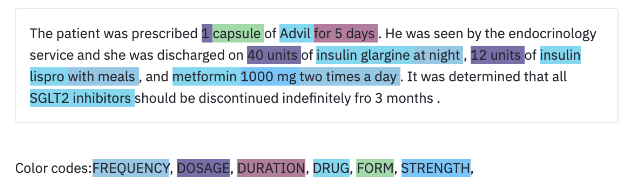

In [44]:
# NER model trained on i2b2 (sampled from MIMIC) dataset
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

posology_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

# greedy model
posology_ner_greedy = MedicalNerModel.pretrained("ner_posology_greedy", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_greedy")

ner_converter_greedy = NerConverterInternal()\
    .setInputCols(["sentence","token","ner_greedy"])\
    .setOutputCol("ner_chunk_greedy")

nlpPipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    posology_ner_converter,
    posology_ner_greedy,
    ner_converter_greedy])

empty_data = spark.createDataFrame([[""]]).toDF("text")

posology_model = nlpPipeline.fit(empty_data)


ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
ner_posology_greedy download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [45]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [46]:
posology_result = posology_model.transform(mt_samples_df).cache()

In [47]:
posology_result.show(10)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|          ner_greedy|    ner_chunk_greedy|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 1609, 16...|[{named_entity, 0...|[{chunk, 1609, 16...|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 742, 750...|[{named_entity, 0...|[{chunk, 742, 753...|
|    2|Sample T

In [48]:
from pyspark.sql.functions import monotonically_increasing_id

# This will return a new DF with all the columns + id
posology_result = posology_result.withColumn("id", monotonically_increasing_id())

posology_result.show(3)

+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|index|                text|            document|            sentence|               token|          embeddings|                 ner|           ner_chunk|          ner_greedy|    ner_chunk_greedy| id|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|    0|Sample Type / Med...|[{document, 0, 54...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 1609, 16...|[{named_entity, 0...|[{chunk, 1609, 16...|  0|
|    1|Sample Type / Med...|[{document, 0, 32...|[{document, 0, 53...|[{token, 0, 5, Sa...|[{word_embeddings...|[{named_entity, 0...|[{chunk, 742, 750...|[{named_entity, 0...|[{chunk, 742, 753...|

In [49]:
posology_result.select('token.result','ner.result').show(truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, Discharge, Sum...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Name, :, BCCa, Excision...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, 

In [50]:
posology_result.select('token.result','ner.result').show(5, truncate=80)

+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|                                                                          result|                                                                          result|
+--------------------------------------------------------------------------------+--------------------------------------------------------------------------------+
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Nam...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Nam...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O...|
|[Sample, Type, /, Medical, Specialty, :, Hematology, -, Oncology, Sample, Nam...|[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O...|
|[Sample, Type, 

In [51]:
from pyspark.sql import functions as F

posology_result.select(F.explode(F.arrays_zip(posology_result.token.result,
                                              posology_result.ner.result,
                                              posology_result.ner.metadata)).alias("cols")) \
               .select(F.expr("cols['0']").alias("token"),
                       F.expr("cols['1']").alias("ner_label"),
                       F.expr("cols['2']['confidence']").alias("confidence"))\
               .filter("ner_label!='O'")\
               .show(20, truncate=100)


+--------------+-----------+----------+
|         token|  ner_label|confidence|
+--------------+-----------+----------+
|      Coumadin|     B-DRUG|    0.9989|
|             1| B-STRENGTH|    0.8618|
|            mg| I-STRENGTH|    0.5132|
|         daily|B-FREQUENCY|    0.9999|
|    Amiodarone|     B-DRUG|    0.9993|
|           100| B-STRENGTH|    0.8538|
|            mg| I-STRENGTH|    0.5216|
|           p.o|    B-ROUTE|    0.9992|
|         daily|B-FREQUENCY|    0.9928|
|      Coumadin|     B-DRUG|    0.9915|
|       Lovenox|     B-DRUG|    0.8314|
|            40| B-STRENGTH|    0.5199|
|            mg| I-STRENGTH|    0.5121|
|subcutaneously|    B-ROUTE|    0.9887|
|  chemotherapy|     B-DRUG|    0.9984|
|     cisplatin|     B-DRUG|    0.9257|
|            75| B-STRENGTH|    0.9574|
| mg/centimeter| I-STRENGTH|    0.5491|
|           109| B-STRENGTH|    0.5699|
|            mg| I-STRENGTH|    0.6355|
+--------------+-----------+----------+
only showing top 20 rows



In [52]:
posology_result.select('id',F.explode(F.arrays_zip(posology_result.ner_chunk.result,
                                                   posology_result.ner_chunk.begin,
                                                   posology_result.ner_chunk.end,
                                                   posology_result.ner_chunk.metadata)).alias("cols")) \
               .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
                             F.expr("cols['0']").alias("chunk"),
                             F.expr("cols['1']").alias("begin"),
                             F.expr("cols['2']").alias("end"),
                             F.expr("cols['3']['entity']").alias("ner_label"),
                             F.expr("cols['3']['confidence']").alias("confidence"))\
                    .filter("ner_label!='O'")\
                    .show(truncate=False)

+---+-----------+----------------+-----+----+---------+----------+
|id |sentence_id|chunk           |begin|end |ner_label|confidence|
+---+-----------+----------------+-----+----+---------+----------+
|0  |33         |Coumadin        |1609 |1616|DRUG     |0.9989    |
|0  |33         |1 mg            |1618 |1621|STRENGTH |0.6875    |
|0  |33         |daily           |1623 |1627|FREQUENCY|0.9999    |
|0  |34         |Amiodarone      |1696 |1705|DRUG     |0.9993    |
|0  |34         |100 mg          |1707 |1712|STRENGTH |0.68770003|
|0  |34         |p.o             |1714 |1716|ROUTE    |0.9992    |
|0  |34         |daily           |1719 |1723|FREQUENCY|0.9928    |
|0  |58         |Coumadin        |2770 |2777|DRUG     |0.9915    |
|0  |60         |Lovenox         |2880 |2886|DRUG     |0.8314    |
|0  |60         |40 mg           |2888 |2892|STRENGTH |0.51600003|
|0  |60         |subcutaneously  |2894 |2907|ROUTE    |0.9887    |
|0  |72         |chemotherapy    |4436 |4447|DRUG     |0.9984 

In [53]:
posology_result.select('id',F.explode(F.arrays_zip(posology_result.ner_chunk_greedy.result,
                                                   posology_result.ner_chunk_greedy.begin,
                                                   posology_result.ner_chunk_greedy.end,
                                                   posology_result.ner_chunk_greedy.metadata)).alias("cols")) \
               .select('id', F.expr("cols['3']['sentence']").alias("sentence_id"),
                             F.expr("cols['0']").alias("chunk"),
                             F.expr("cols['1']").alias("begin"),
                             F.expr("cols['2']").alias("end"),
                             F.expr("cols['3']['entity']").alias("ner_label"),
                             F.expr("cols['3']['confidence']").alias("confidence"))\
                    .filter("ner_label!='O'")\
                    .show(truncate=False)

+---+-----------+--------------------------------------------------------------+-----+----+---------+----------+
|id |sentence_id|chunk                                                         |begin|end |ner_label|confidence|
+---+-----------+--------------------------------------------------------------+-----+----+---------+----------+
|0  |33         |Coumadin 1 mg                                                 |1609 |1621|DRUG     |0.6126    |
|0  |33         |daily                                                         |1623 |1627|FREQUENCY|0.9962    |
|0  |34         |Amiodarone 100 mg p.o                                         |1696 |1716|DRUG     |0.64115   |
|0  |34         |daily                                                         |1719 |1723|FREQUENCY|0.9035    |
|0  |58         |Coumadin                                                      |2770 |2777|DRUG     |0.99      |
|0  |72         |chemotherapy                                                  |4436 |4447|DRUG 

In [54]:
posology_result.select('ner_chunk').take(2)[1][0][0].result

'Xylocaine'

In [55]:
posology_result.select('ner_chunk').take(2)[1][0][0].metadata

{'sentence': '11',
 'chunk': '0',
 'ner_source': 'ner_chunk',
 'entity': 'DRUG',
 'confidence': '0.9906'}

In [56]:
posology_light_model = LightPipeline(posology_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely for 3 months .'

posology_light_result = posology_light_model.annotate(text)

list(zip(posology_light_result['token'], posology_light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was

In [57]:
list(zip(posology_light_result['token'], posology_light_result['ner_greedy']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DRUG'),
 ('capsule', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('Advil', 'I-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DRUG'),
 ('units', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('insulin', 'I-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DRUG'),
 ('units', 'I-DRUG'),
 ('of', 'I-DRUG'),
 ('insulin', 'I-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('and', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'I-DRUG'),
 ('mg', 'I-DRUG'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was', 

In [58]:
posology_light_result = posology_light_model.fullAnnotate(text)

In [59]:
pipeline_tracer = PipelineTracer(posology_model)

column_maps = pipeline_tracer.createParserDictionary()
column_maps.update({"document_identifier": "ner_posology_greedy_pipeline"})
#column_maps

In [60]:
pipeline_tracer.getPossibleEntities()

['DOSAGE', 'STRENGTH', 'ROUTE', 'FREQUENCY', 'DRUG', 'FORM', 'DURATION']

In [61]:
pipeline_parser = PipelineOutputParser(column_maps)
result = pipeline_parser.run(posology_light_result)

posology_result_df = pd.DataFrame.from_dict(result["result"][0]["entities"])
posology_result_df

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,ed29a030,1,27,27,DOSAGE,ner_chunk,0.9992
1,b4474bd8,capsule,29,35,FORM,ner_chunk,0.9897
2,d7d22c27,Advil,40,44,DRUG,ner_chunk,0.997
3,95e5dfab,for 5 days,46,55,DURATION,ner_chunk,0.71383333
4,7dcfc74a,40 units,126,133,DOSAGE,ner_chunk,0.84085
5,7e86e198,insulin glargine,138,153,DRUG,ner_chunk,0.87525
6,9d90a0f9,at night,155,162,FREQUENCY,ner_chunk,0.76839995
7,8193c92d,12 units,166,173,DOSAGE,ner_chunk,0.88755
8,17d78051,insulin lispro,178,191,DRUG,ner_chunk,0.77805
9,2cbe932c,with meals,193,202,FREQUENCY,ner_chunk,0.9213


In [62]:
#This time we use 'ner_posology_greedy' model output
column_maps = {
    'document_identifier': 'ner_posology_pipeline',
    'document_text': 'document',
    'entities': ['ner_chunk_greedy'],
    'assertions': [],
    'resolutions': [],
    'relations': [],
    'summaries': [],
    'deidentifications': [],
    'classifications': []
}

pipeline_parser = PipelineOutputParser(column_maps)
result = pipeline_parser.run(posology_light_result)

posology_result_greedy_df = pd.DataFrame.from_dict(result["result"][0]["entities"])
posology_result_greedy_df

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,6d62be7b,1 capsule of Advil,27,44,DRUG,ner_chunk_greedy,0.636125
1,95e5dfab,for 5 days,46,55,DURATION,ner_chunk_greedy,0.5476
2,ac2abb90,40 units of insulin glargine,126,153,DRUG,ner_chunk_greedy,0.61964
3,9d90a0f9,at night,155,162,FREQUENCY,ner_chunk_greedy,0.7431
4,efb2b741,12 units of insulin lispro,166,191,DRUG,ner_chunk_greedy,0.66034
5,2cbe932c,with meals,193,202,FREQUENCY,ner_chunk_greedy,0.79235005
6,a95079a9,metformin 1000 mg,210,226,DRUG,ner_chunk_greedy,0.70713335
7,a140e8e2,two times a day,228,242,FREQUENCY,ner_chunk_greedy,0.700825
8,453bb6b4,SGLT2 inhibitors,273,288,DRUG,ner_chunk_greedy,0.8847
9,b393cf23,for 3 months,326,337,DURATION,ner_chunk_greedy,0.61083335


### Comparison of `ner_posology` and `ner_posology_greedy` results

In [63]:
posology_light_result= posology_light_model.fullAnnotate(text)

from google.colab import widgets

t = widgets.TabBar(["ner_posology", "ner_posology_greedy", "viz_posology", "viz_posology_greedy"])

with t.output_to(0):
    display(posology_result_df.head(10))

with t.output_to(1):
    display(posology_result_greedy_df.head(10))

with t.output_to(2):
    visualiser.display(posology_light_result[0], label_col='ner_chunk', document_col='document')

with t.output_to(3):
    visualiser.display(posology_light_result[0], label_col='ner_chunk_greedy', document_col='document')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,ed29a030,1,27,27,DOSAGE,ner_chunk,0.9992
1,b4474bd8,capsule,29,35,FORM,ner_chunk,0.9897
2,d7d22c27,Advil,40,44,DRUG,ner_chunk,0.997
3,95e5dfab,for 5 days,46,55,DURATION,ner_chunk,0.71383333
4,7dcfc74a,40 units,126,133,DOSAGE,ner_chunk,0.84085
5,7e86e198,insulin glargine,138,153,DRUG,ner_chunk,0.87525
6,9d90a0f9,at night,155,162,FREQUENCY,ner_chunk,0.76839995
7,8193c92d,12 units,166,173,DOSAGE,ner_chunk,0.88755
8,17d78051,insulin lispro,178,191,DRUG,ner_chunk,0.77805
9,2cbe932c,with meals,193,202,FREQUENCY,ner_chunk,0.9213


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,6d62be7b,1 capsule of Advil,27,44,DRUG,ner_chunk_greedy,0.636125
1,95e5dfab,for 5 days,46,55,DURATION,ner_chunk_greedy,0.5476
2,ac2abb90,40 units of insulin glargine,126,153,DRUG,ner_chunk_greedy,0.61964
3,9d90a0f9,at night,155,162,FREQUENCY,ner_chunk_greedy,0.7431
4,efb2b741,12 units of insulin lispro,166,191,DRUG,ner_chunk_greedy,0.66034
5,2cbe932c,with meals,193,202,FREQUENCY,ner_chunk_greedy,0.79235005
6,a95079a9,metformin 1000 mg,210,226,DRUG,ner_chunk_greedy,0.70713335
7,a140e8e2,two times a day,228,242,FREQUENCY,ner_chunk_greedy,0.700825
8,453bb6b4,SGLT2 inhibitors,273,288,DRUG,ner_chunk_greedy,0.8847
9,b393cf23,for 3 months,326,337,DURATION,ner_chunk_greedy,0.61083335


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Writing a generic NER function

**Generic NER Function with LightPipeline**

In [64]:
def get_pipeline_model(embeddings, model_name = 'ner_clinical'):

  documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

  sentenceDetector = SentenceDetector()\
      .setInputCols(["document"])\
      .setOutputCol("sentence")

  tokenizer = Tokenizer()\
      .setInputCols(["sentence"])\
      .setOutputCol("token")

  word_embeddings = WordEmbeddingsModel.pretrained(embeddings, "en", "clinical/models")\
      .setInputCols(["sentence", "token"])\
      .setOutputCol("embeddings")

  loaded_ner_model = MedicalNerModel.pretrained(model_name, "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings"]) \
      .setOutputCol("ner")

  ner_converter = NerConverterInternal() \
      .setInputCols(["sentence", "token", "ner"]) \
      .setOutputCol("ner_chunk")

  nlpPipeline = Pipeline(stages=[
      documentAssembler,
      sentenceDetector,
      tokenizer,
      word_embeddings,
      loaded_ner_model,
      ner_converter])

  model = nlpPipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

  return model

In [65]:
embeddings = 'embeddings_clinical'

model_name = 'ner_clinical'

light_pipeline_model = get_pipeline_model(embeddings, model_name)

light_model = LightPipeline(light_pipeline_model)

text = "I had a headache yesterday and took an Advil."

light_result = light_model.fullAnnotate(text)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [66]:
pipeline_tracer = PipelineTracer(light_pipeline_model)

column_maps = pipeline_tracer.createParserDictionary()
column_maps.update({"document_identifier": "ner_pipeline"})
#column_maps

In [67]:
pipeline_parser = PipelineOutputParser(column_maps)
result = pipeline_parser.run(light_result)

ner_clinical_df = pd.DataFrame.from_dict(result["result"][0]["entities"])
ner_clinical_df

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,5ee04d99,a headache,6,15,PROBLEM,ner_chunk,0.97545
1,76396a86,an Advil,36,43,TREATMENT,ner_chunk,0.8871


In [68]:
text ='''The patient was prescribed 1 capsule of Parol with meals .
He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day .
It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'''

embeddings = 'embeddings_clinical'

model_name = 'ner_posology'

light_pipeline_model = get_pipeline_model(embeddings, model_name)

light_model = LightPipeline(light_pipeline_model)

light_result = light_model.fullAnnotate(text)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [69]:
pipeline_parser = PipelineOutputParser(column_maps)
result = pipeline_parser.run(light_result)

ner_posology_df = pd.DataFrame.from_dict(result["result"][0]["entities"])
ner_posology_df

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,ed29a030,1,27,27,DOSAGE,ner_chunk,0.9995
1,b4474bd8,capsule,29,35,FORM,ner_chunk,0.989
2,a6805797,Parol,40,44,DRUG,ner_chunk,0.9981
3,40d07556,with meals,46,55,FREQUENCY,ner_chunk,0.89765
4,7dcfc74a,40 units,126,133,DOSAGE,ner_chunk,0.84085
5,7e86e198,insulin glargine,138,153,DRUG,ner_chunk,0.87525
6,9d90a0f9,at night,155,162,FREQUENCY,ner_chunk,0.76839995
7,8193c92d,12 units,166,173,DOSAGE,ner_chunk,0.88755
8,17d78051,insulin lispro,178,191,DRUG,ner_chunk,0.77805
9,2cbe932c,with meals,193,202,FREQUENCY,ner_chunk,0.9213


## PHI NER

**Entities**
- AGE
- CONTACT
- DATE
- ID
- LOCATION
- NAME
- PROFESSION

In [70]:
embeddings = 'embeddings_clinical'

model_name = 'ner_deid_subentity_augmented'

# deidentify_dl
# ner_deid_large
# ner_deid_generic_augmented
# ner_deid_subentity_augmented
# ner_deid_subentity_augmented_i2b2

text = """Miriam BRAY is a 41-year-old female from Vietnam and she was admitted for a right-sided pleural effusion for thoracentesis on Monday by Dr. X. Her Coumadin was placed on hold.
She was instructed to followup with Dr. XYZ in the office to check her INR On August 24, 2007 ."""

light_pipeline_model = get_pipeline_model(embeddings, model_name)

light_model = LightPipeline(light_pipeline_model)

light_result = light_model.fullAnnotate(text)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_subentity_augmented download started this may take some time.
Approximate size to download 14.1 MB
[OK!]


In [71]:
pipeline_parser = PipelineOutputParser(column_maps)
result = pipeline_parser.run(light_result )

ner_deid_subentity_augmented_df = pd.DataFrame.from_dict(result["result"][0]["entities"])
ner_deid_subentity_augmented_df

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,3734a388,Miriam BRAY,0,10,PATIENT,ner_chunk,0.91725
1,eaa5d500,41-year-old,17,27,AGE,ner_chunk,0.9997
2,4e2afa32,Vietnam,41,47,COUNTRY,ner_chunk,0.9934
3,04a3c2b1,Monday,126,131,DATE,ner_chunk,1.0
4,f206db21,X,140,140,DOCTOR,ner_chunk,0.9984
5,43aa1a76,XYZ,216,218,DOCTOR,ner_chunk,1.0
6,de9cb074,"August 24, 2007",254,268,DATE,ner_chunk,0.9994


## Oncology NER

There are several Oncology NER models in Spark NLP. We will show an example of `new_oncology_wip` model here.

**Entities**

| | | | |
|-|-|-|-|
| Invasion | Dosage | Hormonal_Therapy | Site_Lung |
| Biomarker_Result | Response_To_Treatment | Oncogene | Relative_Date |
| Site_Bone | Histological_Type | Radiation_Dose | Age |
| Duration | Grade | Tumor_Size | Line_Of_Therapy |
| Site_Breast | Cancer_Surgery | Smoking_Status | Imaging_Test |
| Adenopathy | Targeted_Therapy | Radiotherapy | Metastasis |
| Date | Cycle_Number | Pathology_Result | Cancer_Score |
| Cancer_Dx | Death_Entity | Site_Liver | Site_Brain |
| Pathology_Test | Chemotherapy | Biomarker | Frequency |
| Site_Lymph_Node | Performance_Status | Unspecific_Therapy | Cycle_Count |
| Race_Ethnicity | Gender | Staging | Immunotherapy |
| Site_Other_Body_Part | Tumor_Finding | Route | Cycle_Day |
| Direction| | | |

You can check [Oncology Model Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/27.Oncology_Model.ipynb) for more examples.


In [72]:
mt_samples_df.limit(1).collect()[0]["text"]

'Sample Type / Medical Specialty:\nHematology - Oncology\nSample Name:\nDischarge Summary - Mesothelioma - 1\nDescription:\nMesothelioma, pleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\n(Medical Transcription Sample Report)\nPRINCIPAL DIAGNOSIS:\nMesothelioma.\nSECONDARY DIAGNOSES:\nPleural effusion, atrial fibrillation, anemia, ascites, esophageal reflux, and history of deep venous thrombosis.\nPROCEDURES\n1. On August 24, 2007, decortication of the lung with pleural biopsy and transpleural fluoroscopy.\n2. On August 20, 2007, thoracentesis.\n3. On August 31, 2007, Port-A-Cath placement.\nHISTORY AND PHYSICAL:\nThe patient is a 41-year-old Vietnamese female with a nonproductive cough that started last week. She has had right-sided chest pain radiating to her back with fever starting yesterday. She has a history of pericarditis and pericardectomy in May 2006 and developed cough with right-sided chest pain, and went to a

In [73]:
embeddings = 'embeddings_clinical'

model_name = 'ner_oncology'

text =  mt_samples_df.limit(1).collect()[0]["text"]

light_pipeline_model = get_pipeline_model(embeddings, model_name)

light_model = LightPipeline(light_pipeline_model)

light_result = light_model.fullAnnotate(text)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_oncology download started this may take some time.
Approximate size to download 33 MB
[OK!]


In [74]:
pipeline_parser = PipelineOutputParser(column_maps)
result = pipeline_parser.run(light_result)

ner_oncology_df = pd.DataFrame.from_dict(result["result"][0]["entities"])
ner_oncology_df

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,4dae1bf0,Mesothelioma,118,129,Cancer_Dx,ner_chunk,0.9983
1,ac2d6c48,"August 24, 2007",471,485,Date,ner_chunk,0.979275
2,5d6162b3,decortication,488,500,Cancer_Surgery,ner_chunk,0.9601
3,1462eae8,lung,509,512,Site_Lung,ner_chunk,0.9918
4,40940231,pleural,519,525,Site_Lung,ner_chunk,0.9582
...,...,...,...,...,...,...,...
105,712b7240,her,5062,5064,Gender,ner_chunk,0.9999
106,614664d9,She,5082,5084,Gender,ner_chunk,1.0
107,e8a6751f,she,5112,5114,Gender,ner_chunk,1.0
108,4acf30b6,mesothelioma,5201,5212,Cancer_Dx,ner_chunk,0.9969


## NER Chunker
We can extract phrases that fits into a known pattern using the NER tags. NerChunker would be quite handy to extract entity groups with neighboring tokens when there is no pretrained NER model to address certain issues. Lets say we want to extract drug and frequency together as a single chunk even if there are some unwanted tokens between them.

In [75]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_chunker = NerChunker()\
    .setInputCols(["sentence","ner"])\
    .setOutputCol("ner_chunk")\
    .setRegexParsers(["<DRUG>.*<FREQUENCY>"])

nlpPipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_chunker])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ner_chunker_model = nlpPipeline.fit(empty_data)

ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [76]:
posology_ner.getClasses()

['O',
 'B-DOSAGE',
 'B-STRENGTH',
 'I-STRENGTH',
 'B-ROUTE',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'B-DRUG',
 'I-DRUG',
 'B-FORM',
 'I-DOSAGE',
 'B-DURATION',
 'I-DURATION',
 'I-FORM',
 'I-ROUTE']

In [77]:
light_model = LightPipeline(ner_chunker_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

list(zip(light_result['token'], light_result['ner']))

[('The', 'O'),
 ('patient', 'O'),
 ('was', 'O'),
 ('prescribed', 'O'),
 ('1', 'B-DOSAGE'),
 ('capsule', 'B-FORM'),
 ('of', 'O'),
 ('Advil', 'B-DRUG'),
 ('for', 'B-DURATION'),
 ('5', 'I-DURATION'),
 ('days', 'I-DURATION'),
 ('.', 'O'),
 ('He', 'O'),
 ('was', 'O'),
 ('seen', 'O'),
 ('by', 'O'),
 ('the', 'O'),
 ('endocrinology', 'O'),
 ('service', 'O'),
 ('and', 'O'),
 ('she', 'O'),
 ('was', 'O'),
 ('discharged', 'O'),
 ('on', 'O'),
 ('40', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('glargine', 'I-DRUG'),
 ('at', 'B-FREQUENCY'),
 ('night', 'I-FREQUENCY'),
 (',', 'O'),
 ('12', 'B-DOSAGE'),
 ('units', 'I-DOSAGE'),
 ('of', 'O'),
 ('insulin', 'B-DRUG'),
 ('lispro', 'I-DRUG'),
 ('with', 'B-FREQUENCY'),
 ('meals', 'I-FREQUENCY'),
 (',', 'O'),
 ('metformin', 'B-DRUG'),
 ('1000', 'B-STRENGTH'),
 ('mg', 'I-STRENGTH'),
 ('two', 'B-FREQUENCY'),
 ('times', 'I-FREQUENCY'),
 ('a', 'I-FREQUENCY'),
 ('day', 'I-FREQUENCY'),
 ('.', 'O'),
 ('It', 'O'),
 ('was', 'O'),
 ('det

In [78]:
light_result["ner_chunk"]

['insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day']

## Chunk Filterer
ChunkFilterer will allow you to filter out named entities by some conditions or predefined look-up lists, so that you can feed these entities to other annotators like Assertion Status or Entity Resolvers. It can be used with two criteria: isin and regex.

In [79]:
posology_ner = MedicalNerModel.pretrained("ner_posology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence","ner_chunk")\
    .setOutputCol("chunk_filtered")\
    .setCriteria("isin")\
    .setWhiteList(['ADVIL','Metformin', 'Insulin Lispro'])\
    .setCaseSensitive(False)

nlpPipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    posology_ner,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

ner_posology download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [80]:
light_model = LightPipeline(chunk_filter_model)

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_result = light_model.annotate(text)

light_result.keys()

dict_keys(['document', 'ner_chunk', 'chunk_filtered', 'token', 'ner', 'embeddings', 'sentence'])

In [81]:
light_result['ner_chunk']

['1',
 'capsule',
 'Advil',
 'for 5 days',
 '40 units',
 'insulin glargine',
 'at night',
 '12 units',
 'insulin lispro',
 'with meals',
 'metformin',
 '1000 mg',
 'two times a day',
 'SGLT2 inhibitors']

In [82]:
light_result['chunk_filtered']

['Advil', 'insulin lispro', 'metformin']

In [83]:
ner_model = MedicalNerModel.pretrained("ner_clinical", "en", "clinical/models")\
    .setInputCols("sentence","token","embeddings")\
    .setOutputCol("ner")

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence","ner_chunk")\
    .setOutputCol("chunk_filtered")\
    .setCriteria("isin")\
    .setWhiteList(['severe fever','sore throat'])\
    .setCaseSensitive(False)

#   .setCriteria("regex")\

nlpPipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    ner_model,
    ner_converter,
    chunk_filterer])

empty_data = spark.createDataFrame([[""]]).toDF("text")

chunk_filter_model = nlpPipeline.fit(empty_data)

ner_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]


In [84]:
text = 'Patient with severe fever, severe cough, sore throat, stomach pain, and a headache.'

filter_df = spark.createDataFrame([[text]]).toDF("text")

chunk_filter_result = chunk_filter_model.transform(filter_df)

In [85]:
chunk_filter_result.select('ner_chunk.result','chunk_filtered.result').show(truncate=False)

+-------------------------------------------------------------------+---------------------------+
|result                                                             |result                     |
+-------------------------------------------------------------------+---------------------------+
|[severe fever, severe cough, sore throat, stomach pain, a headache]|[severe fever, sore throat]|
+-------------------------------------------------------------------+---------------------------+



## ChunkFiltererApproach
ChunkFiltererApproach will allow you to enhance filtering by using JSON-Based Entity Confidence Configuration.

  + `.setEntitiesConfidenceResourceAsJsonString`: You can   fine tune entity confidence levels using a JSON configuration.

In [86]:
chunk_filterer = ChunkFiltererApproach()\
    .setInputCols("sentence","ner_chunk")\
    .setOutputCol("chunk_filtered")\
    .setFilterEntity("entity")\
    .setEntitiesConfidenceResourceAsJsonString("""{'DURATION':'0.9',
                                                  'DOSAGE':'0.9',
                                                  'FREQUENCY':'0.9',
                                                  'STRENGTH':'0.9',
                                                  'DRUG':'0.9'}""")

text ='The patient was prescribed 1 capsule of Advil for 5 days . He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

## Changing entity labels with `NerConverterInternal()`

There are two parameters in `NerConverterInternal()` annotator for replacing the labels.

+ `.setReplaceLabels`: You can just create a dictionary with the labels and their new values in this parameter.

```python
jsl_ner_converter_internal = NerConverterInternal()\
    .setInputCols(["sentence","token","jsl_ner"])\
    .setOutputCol("replaced_ner_chunk")\
    .setReplaceLabels({"Drug_BrandName": "Drug",
                       "Frequency": "Drug_Frequency",
                       "Dosage": "Drug_Dosage",
                       "Strength": "Drug_Strength"})
```

+ `.setReplaceDictResource`: You can feed a file that contains the labels and their new values in a dictionary format.

```python
replace_dict = """Drug_BrandName,Drug
Frequency,Drug_Frequency
Dosage,Drug_Dosage
Strength,Drug_Strength
"""
with open('replace_dict.csv', 'w') as f:
    f.write(replace_dict)

...
jsl_ner_converter_internal = NerConverterInternal()\
    .setInputCols(["sentence","token","jsl_ner"])\
    .setOutputCol("replaced_ner_chunk")\
    .setReplaceDictResource("replace_dict.csv","text", {"delimiter":","})
...
```



You can check [NerConverterInternal Annotator Page](https://nlp.johnsnowlabs.com/docs/en/licensed_annotators#nerconverterinternal) for more details.

In [87]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("jsl_ner")

jsl_ner_converter = NerConverterInternal() \
    .setInputCols(["sentence", "token", "jsl_ner"]) \
    .setOutputCol("jsl_ner_chunk")

jsl_ner_converter_internal = NerConverterInternal()\
    .setInputCols(["sentence","token","jsl_ner"])\
    .setOutputCol("replaced_ner_chunk")\
    .setReplaceLabels({"Drug_BrandName": "Drug",
                       "Frequency": "Drug_Frequency",
                       "Dosage": "Drug_Dosage",
                       "Strength": "Drug_Strength"})

nlpPipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter,
    jsl_ner_converter_internal
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
ner_converter_model = nlpPipeline.fit(empty_data)

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl download started this may take some time.
Approximate size to download 14.5 MB
[OK!]


In [88]:
text ='The patient was prescribed 1 capsule of Parol with meals. He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely fro 3 months .'

light_model = LightPipeline(ner_converter_model)

light_result = light_model.fullAnnotate(text)

In [89]:
column_maps = {
    'document_identifier': 'ner_change_entities_pipeline',
    'document_text': 'document',
    'entities': ['replaced_ner_chunk'],
    'assertions': [],
    'resolutions': [],
    'relations': [],
    'summaries': [],
    'deidentifications': [],
    'classifications': []
}


pipeline_parser = PipelineOutputParser(column_maps)
result = pipeline_parser.run(light_result)

pd.DataFrame.from_dict(result["result"][0]["entities"])

,chunk_id,chunk,begin,end,ner_label,ner_source,ner_confidence
0,756abb2a,1 capsule,27,35,Drug_Dosage,replaced_ner_chunk,0.64855003
1,bfe47642,Parol,40,44,Drug,replaced_ner_chunk,0.8074
2,9b96f3df,He,58,59,Gender,replaced_ner_chunk,1.0
3,41b02293,endocrinology service,77,97,Clinical_Dept,replaced_ner_chunk,0.95285
4,8e5bcdf9,she,103,105,Gender,replaced_ner_chunk,0.9999
5,ace96b0e,discharged,111,120,Admission_Discharge,replaced_ner_chunk,0.9998
6,0dd050e9,40 units,125,132,Drug_Dosage,replaced_ner_chunk,0.7836
7,1f1ba3ac,insulin glargine,137,152,Drug_Ingredient,replaced_ner_chunk,0.72010005
8,70e99bb3,at night,154,161,Drug_Frequency,replaced_ner_chunk,0.9096
9,54f2d377,12 units,165,172,Drug_Dosage,replaced_ner_chunk,0.93044996


### Adding `setIgnoreStopWords` parameter to control chunk generation.
By providing `setIgnoreStopWords`, we can ignore certain words or characters while creating a chunk. <br/>

It should be a list of tokens/words or characters, and when two entities of the same type are separated by those words, these entities can be combined to produce a single, larger chunk.






Firstly let's create `NerConverterInternal()` without this parameter

In [90]:
jsl_ner= MedicalNerModel.pretrained("ner_deid_generic_augmented", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_deid")\
    .setLabelCasing('upper')

jsl_ner_converter_internal= NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_deid"])\
    .setOutputCol("chunk_deid")\
    .setGreedyMode(True)\
    .setWhiteList(['LOCATION'])

nlpPipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter_internal
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
ner_converter_model = nlpPipeline.fit(empty_data)

ner_deid_generic_augmented download started this may take some time.
Approximate size to download 13.8 MB
[OK!]


In [91]:
from sparknlp_display import NerVisualizer

text = """
The address of the manufacturer:
R K Industry House, Walbhat Rd
Mumbai, Maharashtra, India
"""

lmodel= LightPipeline(ner_converter_model)
res = lmodel.fullAnnotate(text)[0]

NerVisualizer().display(res, 'chunk_deid')

Now, let's define some characters and words with the `setIgnoreStopWords()` parameter and see the difference between the chunks.

In [92]:
jsl_ner_converter_internal= NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_deid"])\
    .setOutputCol("chunk_deid")\
    .setGreedyMode(True)\
    .setWhiteList(['LOCATION'])\
    .setIgnoreStopWords(['\n', ',', "and", 'or', '.'])

nlpPipeline = Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    word_embeddings,
    jsl_ner,
    jsl_ner_converter_internal
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")
ner_converter_model = nlpPipeline.fit(empty_data)

In [93]:
lmodel= LightPipeline(ner_converter_model)
res = lmodel.fullAnnotate(text)[0]

NerVisualizer().display(res, 'chunk_deid')

## Downloading Pretrained Models

- When we use `.pretrained` method, model is downloaded to  a folder named `cache_pretrained` automatically and it is loaded from this folder if you run it again.

- In order to download the models manually to any folder, you can use `ResourceDownloader.downloadModelDirectly` from `sparknlp.pretrained` or AWS CLI (steps below). In this case you should use `.load()` method.

  - Install AWS CLI to your local computer following the steps [here](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-linux.html) for Linux and [here](https://docs.aws.amazon.com/cli/latest/userguide/install-cliv2-mac.html) for MacOS.

  - Then configure your AWS credentials.

  - Go to models hub and look for the model you need.

  - Select the model you found and you will see the model card that shows all the details about that model.

  - Hover the Download button on that page and you will see the download link from the S3 bucket.


In [94]:
!cd /root && ls

cache_pretrained


In [95]:
from sparknlp.pretrained import ResourceDownloader

#The first argument is the path to the zip file and the second one is the folder.
ResourceDownloader.downloadModelDirectly("clinical/models/ner_jsl_en_3.1.0_2.4_1624566960534.zip", "cache_pretrained")

#or you can use the classic AWS CLI
# !aws s3 cp --region us-east-2 s3://auxdata.johnsnowlabs.com/clinical/models/ner_jsl_en_3.1.0_2.4_1624566960534.zip .

## Training a Clinical NER (NCBI Disease Dataset)

`CoNLL(includeDocId=True).readDataset(spark, "conll_file.txt")`  this methos can allow if you have doc_id information in the conll file, you can add this information to the dataframe as a column.

```
conll="""-DOCSTART- -X- -1- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O

-DOCSTART- -X- 2 O

Rare NNP B-NP O
Hendrix NNP I-NP B-PER

-DOCSTART- -X- -3- O

China NNP B-NP B-LOC
says VBZ B-VP O

-DOCSTART-

China NNP B-NP B-LOC
says VBZ B-VP O
"""
```
```
with open('conll_file.txt', 'w') as f:
    f.write(conll)

data = CoNLL(includeDocId=True).readDataset(spark, "conll_file.txt")

data.show()
```



```
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|doc_id|                text|            document|            sentence|               token|                 pos|               label|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     1|EU rejects German...|[{document, 0, 28...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
|     2|Rare Hendrix song...|[{document, 0, 97...|[{document, 0, 50...|[{token, 0, 3, Ra...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|
|     3|China says Taiwan...|[{document, 0, 13...|[{document, 0, 46...|[{token, 0, 4, Ch...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
|     X|China says Taiwan...|[{document, 0, 13...|[{document, 0, 46...|[{token, 0, 4, Ch...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
+------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
```

In [96]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltrain.txt
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/data/NER_NCBIconlltest.txt

In [97]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'NER_NCBIconlltrain.txt')

conll_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Identification of...|[{document, 0, 89...|[{document, 0, 89...|[{token, 0, 13, I...|[{pos, 0, 13, NN,...|[{named_entity, 0...|
|The adenomatous p...|[{document, 0, 21...|[{document, 0, 21...|[{token, 0, 2, Th...|[{pos, 0, 2, NN, ...|[{named_entity, 0...|
|Complex formation...|[{document, 0, 63...|[{document, 0, 63...|[{token, 0, 6, Co...|[{pos, 0, 6, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [98]:
conll_data.count()

3266

In [99]:
from pyspark.sql import functions as F

conll_data.select(F.explode(F.arrays_zip(conll_data.token.result,
                                         conll_data.label.result)).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)

+------------+-----+
|ground_truth|count|
+------------+-----+
|O           |75093|
|I-Disease   |3547 |
|B-Disease   |3093 |
+------------+-----+



In [100]:
conll_data.select("label.result").distinct().count()

1537

In [101]:
'''
As you can see, there are too many `O` labels in the dataset.
To make it more balanced, we can drop the sentences have only O labels.
(`c>1` means we drop all the sentences that have no valuable labels other than `O`)
'''

'''
conll_data = conll_data.withColumn('unique', F.array_distinct("label.result"))\
                       .withColumn('c', F.size('unique'))\
                       .filter(F.col('c')>1)

conll_data.select(F.explode(F.arrays_zip(conll_data.token.result,conll_data.label.result)).alias("cols")) \
          .select(F.expr("cols['0']").alias("token"),
                  F.expr("cols['1']").alias("ground_truth"))\
          .groupBy('ground_truth')\
          .count()\
          .orderBy('count', ascending=False)\
          .show(100,truncate=False)
'''

'\nconll_data = conll_data.withColumn(\'unique\', F.array_distinct("label.result"))                       .withColumn(\'c\', F.size(\'unique\'))                       .filter(F.col(\'c\')>1)\n\nconll_data.select(F.explode(F.arrays_zip(conll_data.token.result,conll_data.label.result)).alias("cols"))           .select(F.expr("cols[\'0\']").alias("token"),\n                  F.expr("cols[\'1\']").alias("ground_truth"))          .groupBy(\'ground_truth\')          .count()          .orderBy(\'count\', ascending=False)          .show(100,truncate=False)\n'

In [102]:
# Clinical word embeddings trained on PubMED dataset
clinical_embeddings = WordEmbeddingsModel.pretrained('embeddings_clinical', "en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


In [103]:
test_data = CoNLL().readDataset(spark, 'NER_NCBIconlltest.txt')

test_data = clinical_embeddings.transform(test_data)

test_data.write.mode("overwrite").parquet('NER_NCBIconlltest.parquet')

### MedicalNerDLGraphChecker for NER Training

The MedicalNerDLGraphChecker processes the dataset to extract required graph parameters (tokens, labels, embedding dimensions)

In [110]:
nerDLGraphChecker = MedicalNerDLGraphChecker()\
    .setInputCols(["sentence", "token"])\
    .setLabelColumn("label")\
    .setEmbeddingsModel(clinical_embeddings)

In [111]:
nerTagger = MedicalNerApproach()\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setLabelColumn("label")\
    .setOutputCol("ner")\
    .setMaxEpochs(30)\
    .setBatchSize(64)\
    .setRandomSeed(0)\
    .setVerbose(1)\
    .setValidationSplit(0.2)\
    .setEvaluationLogExtended(True) \
    .setEnableOutputLogs(True)\
    .setIncludeConfidence(True)\
    .setOutputLogsPath('ner_logs')\
    .setUseBestModel(True)\
    .setEarlyStoppingCriterion(0.01)\
    .setEarlyStoppingPatience(5)\
    #.setTestDataset("NER_NCBIconlltest.parquet")\
    #.setEnableMemoryOptimizer(True) #>> if you have a limited memory and a large conll file, you can set this True to train batch by batch
    #.setDatasetInfo("NCBI_sample_short dataset") #You can add details regarding the dataset

ner_pipeline = Pipeline(stages=[
          clinical_embeddings,
          nerDLGraphChecker,
          nerTagger
 ])

You can visit [1.4.Resume_MedicalNer_Model_Training.ipynb](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.4.Resume_MedicalNer_Model_Training.ipynb) notebook for fine-tuning pretrained NER models and more details of `MedicalNerApproach()` parameters.

In [112]:
%%time
ner_model = ner_pipeline.fit(conll_data)

CPU times: user 116 ms, sys: 50.9 ms, total: 166 ms
Wall time: 13min 23s



`getTrainingClassDistribution()` parameter returns the distribution of labels used when training the NER model.

In [113]:
ner_model.stages[2].getTrainingClassDistribution()

{'O': 75093, 'B-Disease': 3093, 'I-Disease': 3547}

Let's check the results saved in the log file.

In [114]:
import os
log_file= os.listdir("ner_logs")[0]

with open (f"./ner_logs/{log_file}") as f:
  print(f.read())

Name of the selected graph: medical-ner-dl/blstm_100_200_128_100.pb
Training started - total epochs: 30 - lr: 0.001 - batch size: 64 - labels: 3 - chars: 84 - training examples: 3266


Epoch 1/30 started, lr: 0.001, dataset size: 3266


Epoch 1/30 - 27.75s - loss: 623.39886 - avg training loss: 14.497648 - batches: 43
Quality on validation dataset (20.0%), validation examples = 653
time to finish evaluation: 9.38s
Total validation loss: 59.6437	Avg validation loss: 4.2603
label	 tp	 fp	 fn	 prec	 rec	 f1
I-Disease	 174	 48	 524	 0.7837838	 0.24928367	 0.37826088
B-Disease	 171	 67	 492	 0.7184874	 0.25791857	 0.37957826
tp: 345 fp: 115 fn: 1016 labels: 2
Macro-average	 prec: 0.7511356, rec: 0.25360113, f1: 0.3791816
Micro-average	 prec: 0.75, rec: 0.2534901, f1: 0.3789127


Epoch 2/30 started, lr: 9.950249E-4, dataset size: 3266


Epoch 2/30 - 24.01s - loss: 199.03181 - avg training loss: 4.628647 - batches: 43
Quality on validation dataset (20.0%), validation examples = 653
time to fi

As you see above, our **earlyStopping** feature worked, trainining was terminated before 30th epoch.

### Evaluate your model

In [115]:
pred_df = ner_model.stages[2].transform(test_data)

In [116]:
pred_df.columns

['text', 'document', 'sentence', 'token', 'pos', 'label', 'embeddings', 'ner']

In [117]:
from sparknlp_jsl.eval import NerDLMetrics
import pyspark.sql.functions as F

evaler = NerDLMetrics(mode="full_chunk")

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+-----+-----+----+-----+---------+------+------+
| entity|   tp|   fp|  fn|total|precision|recall|    f1|
+-------+-----+-----+----+-----+---------+------+------+
|Disease|610.0|116.0|94.0|704.0|   0.8402|0.8665|0.8531|
+-------+-----+-----+----+-----+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.8531468531468531|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.8531468531468532|
+------------------+

None


In [118]:
evaler = NerDLMetrics(mode="partial_chunk_per_token")

eval_result = evaler.computeMetricsFromDF(pred_df.select("label","ner"), prediction_col="ner", label_col="label", drop_o = True, case_sensitive = True).cache()

eval_result.withColumn("precision", F.round(eval_result["precision"],4))\
           .withColumn("recall", F.round(eval_result["recall"],4))\
           .withColumn("f1", F.round(eval_result["f1"],4)).show(100)

print(eval_result.selectExpr("avg(f1) as macro").show())
print (eval_result.selectExpr("sum(f1*total) as sumprod","sum(total) as sumtotal").selectExpr("sumprod/sumtotal as micro").show())

+-------+------+-----+-----+------+---------+------+------+
| entity|    tp|   fp|   fn| total|precision|recall|    f1|
+-------+------+-----+-----+------+---------+------+------+
|Disease|1362.0|127.0|135.0|1497.0|   0.9147|0.9098|0.9123|
+-------+------+-----+-----+------+---------+------+------+

+------------------+
|             macro|
+------------------+
|0.9122572002679169|
+------------------+

None
+------------------+
|             micro|
+------------------+
|0.9122572002679169|
+------------------+

None


`ner_utils`: This new module is used after NER training to calculate mertic chunkbase and plot training logs.

`evaluate`: if verbose, returns overall performance, as well as performance per chunk type; otherwise, simply returns overall precision, recall, f1 scores

`loss_plot`: Plots the figure of loss vs epochs

`get_charts` : Plots the figures of metrics ( precision, recall, f1) vs epochs

```
from sparknlp_jsl.training_log_parser import ner_log_parser
parser = ner_log_parser()

pred_df = ner_model.stages[2].transform(test_data)
pred_df = pred_df.select(F.explode(F.arrays_zip(pred_df.ner.result,
                                                pred_df.label.result)).alias("cols"))\
                 .select(F.expr("cols['0']").alias("prediction"),
                         F.expr("cols['1']").alias("ground_truth"))
                 
df = pred_df.toPandas()

metrics = parser.evaluate( df['prediction'].values, df['ground_truth'].values)

parser.loss_plot(f"./ner_logs/{log_file}")

parser.get_charts('./ner_logs/'+log_file)
```

In [119]:
ner_model.stages[2].write().overwrite().save('models/custom_NER_model')

In [120]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

loaded_ner_model = MedicalNerModel.load("models/custom_NER_model")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

converter = NerConverterInternal()\
    .setInputCols(["document", "token", "ner"])\
    .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(stages=[
    document,
    sentence,
    token,
    clinical_embeddings,
    loaded_ner_model,
    converter])

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)

from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [121]:
text = "She has a metastatic breast cancer"

result = light_model.fullAnnotate(text)[0]

[(i.result, i.metadata['entity']) for i in result['ner_span']]

[('metastatic breast cancer', 'Disease')]

## BertForTokenClassification NER models

In [122]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols("sentence")\
    .setOutputCol("token")

tokenClassifier = MedicalBertForTokenClassifier.pretrained("bert_token_classifier_ner_clinical", "en", "clinical/models")\
    .setInputCols("token", "sentence")\
    .setOutputCol("ner")\
    .setCaseSensitive(True)

ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner"])\
    .setOutputCol("ner_chunk")

pipeline =  Pipeline(stages=[
    documentAssembler,
    sentenceDetector,
    tokenizer,
    tokenClassifier,
    ner_converter
    ])

model = pipeline.fit(spark.createDataFrame([[""]]).toDF("text"))

text = """A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting .
Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection .
She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation .
Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity .
Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 .
Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia .
The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission .
However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L .
The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again .
The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours .
Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use .
The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day .
It was determined that all SGLT2 inhibitors should be discontinued indefinitely . She had close follow-up with endocrinology post discharge ."""

res = model.transform(spark.createDataFrame([[text]]).toDF("text"))

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
bert_token_classifier_ner_clinical download started this may take some time.
Approximate size to download 385.6 MB
[OK!]


In [123]:
from pyspark.sql import functions as F

res.select(F.explode(F.arrays_zip(res.ner_chunk.result,
                                  res.ner_chunk.begin,
                                  res.ner_chunk.end,
                                  res.ner_chunk.metadata)).alias("cols")) \
   .select(F.expr("cols['3']['sentence']").alias("sentence_id"),
           F.expr("cols['0']").alias("chunk"),
           F.expr("cols['1']").alias("begin"),
           F.expr("cols['2']").alias("end"),
           F.expr("cols['3']['entity']").alias("ner_label"))\
   .filter("ner_label!='O'")\
   .show(truncate=False)

+-----------+-----------------------------+-----+---+---------+
|sentence_id|chunk                        |begin|end|ner_label|
+-----------+-----------------------------+-----+---+---------+
|0          |gestational diabetes mellitus|39   |67 |PROBLEM  |
|0          |type two diabetes mellitus ( |128  |155|PROBLEM  |
|0          |T2DM ),                      |157  |163|PROBLEM  |
|0          |HTG-induced pancreatitis     |186  |209|PROBLEM  |
|0          |an acute hepatitis           |263  |280|PROBLEM  |
|0          |obesity                      |288  |294|PROBLEM  |
|0          |a body mass index            |301  |317|TEST     |
|0          |BMI                          |321  |323|TEST     |
|0          |polyuria                     |380  |387|PROBLEM  |
|0          |polydipsia                   |391  |400|PROBLEM  |
|0          |poor appetite                |404  |416|PROBLEM  |
|0          |vomiting                     |424  |431|PROBLEM  |
|1          |amoxicillin                

In [124]:
light_model = LightPipeline(model)

light_result = light_model.fullAnnotate(text)

from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(light_result[0], label_col='ner_chunk', document_col='document', save_path="display_bert_result.html")

**Training Clinical BertForTokenClassification Model**

For training own BertForTokenClassification NER model, you can check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.5.BertForTokenClassification_NER_SparkNLP_with_Transformers.ipynb)

## Pretrained NER Profiling Pipelines

We can use pretrained NER profiling pipelines for exploring all the available pretrained NER models at once. In Spark NLP we have two different NER profiling pipelines;

- `ner_profiling_clinical` : Returns results for clinical NER models trained with `embeddings_clinical`.
- `ner_profiling_biobert` : Returns results for clinical NER models trained with `biobert_pubmed_base_cased`.

For more examples, please check [this notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/11.2.Pretrained_NER_Profiling_Pipelines.ipynb).





<center><b>NER Profiling Clinical Model List</b>

|| | | |
|--------------|-----------------|-----------------|-----------------|
| jsl_ner_wip_clinical               | jsl_ner_wip_greedy_clinical                    | jsl_rd_ner_wip_greedy_clinical   | jsl_ner_wip_modifier_clinical |
| ner_abbreviation_clinical          | ner_ade_binary                                 | ner_ade_clinical                 | ner_anatomy          |
| ner_anatomy_coarse                  | ner_bacterial_species                          | ner_biomedical_bc2gm             | ner_biomarker        |
| ner_bionlp                          | ner_chemicals                                  | ner_chemd_clinical               | ner_chemprot_clinical|
| ner_chexpert                        | ner_clinical                                   | ner_clinical_large               | ner_clinical_trials_abstracts  |
| ner_covid_trials                    | ner_deid_augmented                             | ner_deid_enriched                | ner_deid_generic_augmented |
| ner_deid_large                      | ner_deid_sd                                    | ner_deid_sd_large                | ner_deid_subentity_augmented |
| ner_diseases                        | ner_diseases_large                             | ner_drugprot_clinical            | ner_drugs             |
| ner_drugs_greedy                    | ner_drugs_large                                | ner_eu_clinical_case             | ner_eu_clinical_condition                       |
| ner_events_admission_clinical       | ner_events_clinical                            | ner_genetic_variants             | ner_human_phenotype_gene_clinical |
| ner_human_phenotype_go_clinical     | ner_jsl                                        | ner_jsl_enriched                 | ner_jsl_greedy        |
| ner_jsl_slim                        | ner_living_species                             | ner_measurements_clinical        | ner_medmentions_coarse |
| ner_nature_nero_clinical            | ner_nihss                                      | ner_oncology                     | ner_oncology_anatomy_general |
| ner_oncology_anatomy_granular       | ner_oncology_biomarker                         | ner_oncology_demographics        | ner_oncology_diagnosis |
| ner_oncology_posology               | ner_oncology_response_to_treatment             | ner_oncology_tnm                 | ner_oncology_therapy  |
| ner_oncology_unspecific_posology    | ner_oncology_wip                               | ner_pathogen                     | ner_posology           |
| ner_posology_experimental           | ner_posology_greedy                            | ner_posology_large               | ner_posology_small    |
| ner_posology_wip                    | ner_radiology                                  | ner_radiology_wip_clinical       | ner_risk_factors      |
| ner_sdoh_access_to_healthcare_wip   | ner_sdoh_community_condition_wip               | ner_sdoh_demographics_wip        | ner_sdoh_health_behaviours_problems_wip |
| ner_sdoh_income_social_status_wip   | ner_sdoh_mentions                              | ner_sdoh_social_environment_wip  | ner_sdoh_substance_usage_wip |
| ner_sdoh_wip                        | ner_supplement_clinical                        | ner_token                        | ner_vop_anatomy_wip   |
| ner_vop_clinical_dept_wip           | ner_vop_demographic_wip                        | ner_vop_problem_reduced_wip      | ner_vop_problem_wip   |
| ner_vop_slim_wip                    | ner_vop_temporal_wip                           | ner_vop_test_wip                 | ner_vop_treatment_wip |
| ner_vop_wip                         |                                                |                                 |                       |


|| | | |
|--------------|-----------------|-----------------|-----------------|
| explain_clinical_doc_generic   | jsl_ner_wip_clinical_pipeline  | jsl_ner_wip_greedy_clinical_pipeline | jsl_ner_wip_modifier_clinical_pipeline |
| jsl_rd_ner_wip_greedy_clinical_pipeline | ner_abbreviation_clinical_pipeline | ner_ade_clinical_langtest_pipeline | ner_ade_clinical_pipeline      |
| ner_anatomy_coarse_pipeline    | ner_anatomy_pipeline           | ner_bacterial_species_pipeline | ner_biomarker_pipeline         |
| ner_biomedical_bc2gm_pipeline  | ner_bionlp_pipeline            | ner_cancer_genetics_pipeline   | ner_cellular_pipeline          |
| ner_chemd_clinical_pipeline    | ner_chemicals_pipeline         | ner_chemprot_clinical_pipeline | ner_chexpert_pipeline          |
| ner_clinical_large_pipeline    | ner_clinical_pipeline          | ner_clinical_trials_abstracts_pipeline | ner_covid_trials_pipeline      |
| ner_deid_augmented_pipeline    | ner_deid_enriched_pipeline     | ner_deid_generic_augmented_pipeline | ner_deid_generic_glove_pipeline |
| ner_deid_generic_pipeline      | ner_deid_large_pipeline        | ner_deid_sd_large_pipeline     | ner_deid_sd_pipeline           |
| ner_deid_subentity_augmented_pipeline | ner_deid_subentity_glove_pipeline | ner_deid_subentity_pipeline    | ner_deid_synthetic_pipeline    |
| ner_deidentify_dl_pipeline     | ner_diag_proc_pipeline         | ner_diseases_large_pipeline    | ner_diseases_pipeline          |
| ner_drugprot_clinical_pipeline | ner_drugs_greedy_pipeline      | ner_drugs_large_pipeline       | ner_drugs_pipeline             |
| ner_eu_clinical_case_pipeline  | ner_eu_clinical_condition_pipeline | ner_events_admission_clinical_pipeline | ner_events_clinical_langtest_pipeline |
| ner_events_clinical_pipeline   | ner_genetic_variants_pipeline  | ner_human_phenotype_gene_clinical_pipeline | ner_human_phenotype_go_clinical_pipeline |
| ner_jsl_enriched_pipeline      | ner_jsl_greedy_pipeline        | ner_jsl_langtest_pipeline      | ner_jsl_pipeline               |
| ner_jsl_slim_pipeline          | ner_living_species_300_pipeline | ner_living_species_pipeline    | ner_measurements_clinical_pipeline |
| ner_medmentions_coarse_pipeline | ner_nature_nero_clinical_pipeline | ner_negation_uncertainty_pipeline | ner_neoplasms_pipeline         |
| ner_nihss_pipeline             | ner_oncology_anatomy_general_langtest_pipeline | ner_oncology_anatomy_general_pipeline | ner_oncology_anatomy_granular_langtest_pipeline |
| ner_oncology_anatomy_granular_pipeline | ner_oncology_biomarker_pipeline | ner_oncology_demographics_langtest_pipeline | ner_oncology_demographics_pipeline |
| ner_oncology_diagnosis_pipeline | ner_oncology_pipeline          | ner_oncology_posology_langtest_pipeline | ner_oncology_posology_pipeline |
| ner_oncology_response_to_treatment_langtest_pipeline | ner_oncology_response_to_treatment_pipeline | ner_oncology_test_pipeline     | ner_oncology_therapy_pipeline  |
| ner_oncology_tnm_pipeline      | ner_oncology_unspecific_posology_pipeline | ner_pathogen_pipeline          | ner_pharmacology_pipeline      |
| ner_posology_experimental_pipeline | ner_posology_greedy_pipeline   | ner_posology_langtest_pipeline | ner_posology_large_pipeline    |
| ner_posology_pipeline          | ner_posology_small_pipeline    | ner_profiling_clinical         | ner_profiling_oncology         |
| ner_profiling_sdoh             | ner_profiling_vop              | ner_radiology_pipeline         | ner_radiology_wip_clinical_pipeline |
| ner_risk_factors_pipeline      | ner_sdoh_langtest_pipeline     | ner_sdoh_mentions_pipeline     | ner_supplement_clinical_pipeline |
| ner_vop_anatomy_pipeline       | ner_vop_clinical_dept_pipeline | ner_vop_demographic_pipeline   | ner_vop_pipeline               |
| ner_vop_problem_pipeline       | ner_vop_problem_reduced_pipeline | ner_vop_temporal_pipeline      | ner_vop_test_pipeline          |
| ner_vop_treatment_pipeline     | nerdl_tumour_demo_pipeline     | oncology_general_pipeline      |                       |


<b>NER Profiling BioBert Model List</b>

| | |
|-|-|
| ner_cellular_biobert           | ner_clinical_biobert             |
| ner_diseases_biobert           | ner_anatomy_coarse_biobert       |
| ner_events_biobert             | ner_human_phenotype_gene_biobert |
| ner_bionlp_biobert             | ner_posology_large_biobert       |
| ner_jsl_greedy_biobert         | jsl_rd_ner_wip_greedy_biobert    |
| ner_jsl_biobert                | ner_posology_biobert             |
| ner_anatomy_biobert            | jsl_ner_wip_greedy_biobert       |
| ner_jsl_enriched_biobert       | ner_chemprot_biobert             |
| ner_human_phenotype_go_biobert | ner_ade_biobert                  |
| ner_deid_biobert               | ner_risk_factors_biobert         |
| ner_deid_enriched_biobert      | ner_living_species_biobert       |


</center>


In [125]:
from sparknlp.pretrained import PretrainedPipeline

clinical_profiling_pipeline = PretrainedPipeline("ner_profiling_clinical", "en", "clinical/models")

ner_profiling_clinical download started this may take some time.
Approx size to download 3.6 GB
[OK!]


In [126]:
text = '''A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), one prior episode of HTG-induced pancreatitis three years prior to presentation , associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting .'''

In [127]:
clinical_result = clinical_profiling_pipeline.fullAnnotate(text)[0]
clinical_result.keys()

dict_keys(['ner_oncology_tnm_langtest', 'ner_ade_clinical_chunks', 'ner_deid_augmented', 'ner_deid_subentity_augmented_i2b2', 'ner_posology_greedy_chunks', 'ner_risk_factors_langtest_chunks', 'ner_sdoh_substance_usage_chunks', 'ner_sdoh_demographics_chunks', 'ner_vop_clinical_dept_langtest', 'ner_human_phenotype_gene_clinical_langtest_chunks', 'ner_clinical_abbreviation_langtest_chunks', 'ner_risk_factors_langtest', 'ner_radiology_wip_clinical', 'ner_deidentify_dl', 'ner_oncology_diagnosis_chunks', 'ner_vop_v2', 'ner_vop_treatment_langtest_chunks', 'ner_jsl_slim', 'ner_vop_anatomy_langtest_chunks', 'ner_vop_clinical_dept_chunks', 'ner_ade_clinical_langtest', 'ner_vop_langtest_chunks', 'ner_risk_factors_chunks', 'jsl_ner_wip_clinical_chunks', 'ner_deid_subentity_augmented_langtest', 'ner_oncology_unspecific_posology_chunks', 'ner_oncology_demographics_langtest_chunks', 'ner_eu_clinical_case_chunks', 'ner_deid_large_langtest_chunks', 'ner_oncology_test_chunks', 'ner_vop_demographic_chunk

In [128]:
def get_token_results(light_result):

  tokens = [j.result for j in light_result["token"]]
  sentences = [j.metadata["sentence"] for j in light_result["token"]]
  begins = [j.begin for j in light_result["token"]]
  ends = [j.end for j in light_result["token"]]
  model_list = [ a for a in light_result.keys() if (a not in ["sentence", "token"] and "_chunks" not in a)]

  df = pd.DataFrame({'sentence':sentences, 'begin': begins, 'end': ends, 'token':tokens})

  for model_name in model_list:

    temp_df = pd.DataFrame(light_result[model_name])
    temp_df["jsl_label"] = temp_df.iloc[:,0].apply(lambda x : x.result)
    temp_df = temp_df[["jsl_label"]]

    # temp_df = get_ner_result(model_name)
    temp_df.columns = [model_name]
    df = pd.concat([df, temp_df], axis=1)

  return df

In [129]:
get_token_results(clinical_result)

,sentence,begin,end,token,ner_oncology_tnm_langtest,ner_deid_augmented,ner_deid_subentity_augmented_i2b2,ner_vop_clinical_dept_langtest,ner_risk_factors_langtest,ner_radiology_wip_clinical,...,ner_clinical_langtest,ner_oncology_unspecific_posology,ner_genetic_variants,ner_radiology,ner_eu_clinical_case,ner_posology,ner_oncology_posology,ner_covid_trials,ner_vop_problem_reduced_langtest,ner_posology_langtest
0,0,0,0,A,O,O,O,O,O,O,...,O,O,O,O,B-patient,O,O,O,O,O
1,0,2,12,28-year-old,O,O,O,O,O,O,...,O,O,O,O,I-patient,O,O,B-Gender,O,O
2,0,14,19,female,O,O,O,O,O,O,...,O,O,O,O,I-patient,O,O,B-Gender,O,O
3,0,21,24,with,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
4,0,26,26,a,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0,409,416,appetite,O,O,O,O,O,I-Symptom,...,I-PROBLEM,O,O,I-Symptom,I-clinical_condition,O,O,O,I-Problem,O
69,0,418,418,",",O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
70,0,420,422,and,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O
71,0,424,431,vomiting,O,O,O,O,O,B-Symptom,...,B-PROBLEM,O,O,B-Symptom,B-clinical_condition,O,O,O,B-Problem,O


**Lets plot the labelled entity counts by NER models.**

In [130]:
import plotly.graph_objects as go

result_df = get_token_results(clinical_result)

label_result_df = result_df[result_df.columns[4:]].copy()
label_count_list = [label_result_df[label_result_df[i] != "O"].shape[0] for i in label_result_df.columns]

fig = go.Figure(go.Bar(x=label_count_list, y=label_result_df.columns, orientation='h'))

fig.update_layout(
    autosize = False,
    width = 1500,
    height = 1500,
    margin = dict(l=50, r=50, b=100, t=100, pad=4),
    paper_bgcolor = "LightSteelBlue",
    title={'text': "Counts of Labelled Entities", 'y':0.98, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    titlefont=dict(size=30),
    yaxis=dict(title_text="Clinical NER Models", titlefont=dict(size=30)),
)

fig.show()

## NER Model Finder Pretrained Pipeline
`ner_model_finder`  pretrained pipeline trained with bert embeddings that can be used to find the most appropriate NER model given the entity name.

In [131]:
from sparknlp.pretrained import PretrainedPipeline
finder_pipeline = PretrainedPipeline("ner_model_finder", "en", "clinical/models")

ner_model_finder download started this may take some time.
Approx size to download 148.7 MB
[OK!]


In [132]:
result = finder_pipeline.fullAnnotate("oncology")[0]
result.keys()

dict_keys(['model_names'])

From the metadata in the `model_names` column, we'll get to the top models to the given 'oncology' entity and oncology related categories.

In [133]:
df= pd.DataFrame(zip(result["model_names"][0].metadata["all_k_resolutions"].split(":::"),
                     result["model_names"][0].metadata["all_k_results"].split(":::")),
                 columns=["category", "top_models"])

df.head()

,category,top_models
0,oncology therapy,"['ner_jsl', 'jsl_rd_ner_wip_greedy_clinical', 'jsl_ner_wip_modifier_clinical', 'ner_jsl_enriched', 'ner_jsl_greedy', 'ner_jsl_slim']"
1,clinical department,"['ner_jsl', 'jsl_rd_ner_wip_greedy_clinical', 'jsl_ner_wip_modifier_clinical', 'ner_events_clinical', 'ner_jsl_enriched', 'ner_jsl_greedy', 'ner_jsl_slim', 'ner_events_healthcare', 'ner_events_adm..."
2,biomedical unit,['ner_clinical_trials_abstracts']
3,cancer genetics,['ner_cancer_genetics']
4,anatomy,"['ner_bionlp', 'ner_medmentions_coarse', 'ner_chexpert', 'ner_anatomy_coarse', 'ner_anatomy', 'ner_nature_nero_clinical']"


## ContextualEntityFilterer

The ContextualEntityFilterer annotator was developed to prevent certain entities from causing interference. It can be used to filter out specific entities, ensuring accurate results are preserved. Please see [ContextualEntityFilterer MOOC Notebook](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/Spark_NLP_Udemy_MOOC/Healthcare_NLP/ContextualEntityFilterer.ipynb) for more details.

In [134]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")

ner_oncology = MedicalNerModel.pretrained("ner_oncology", "en", "clinical/models")  \
    .setInputCols(["document", "token", "embeddings"]) \
    .setOutputCol("ner_oncology")

ner_oncology_converter = NerConverterInternal()\
    .setInputCols(["document", "token", "ner_oncology"])\
    .setOutputCol("ner_chunk_oncology")

rules =[{
    "entity": "Biomarker",
    "scopeWindow": [2, 2],
    "whiteListEntities": ["Biomarker_Result"],
    "scopeWindowLevel": "token"
}]

contextual_entity_filterer = ContextualEntityFilterer() \
    .setInputCols("document", "token", "ner_chunk_oncology") \
    .setOutputCol("filtered_ner_chunks") \
    .setRules(rules)\
    .setRuleScope("sentence") # document

nlpPipeline = Pipeline(stages=[
    documentAssembler,
    tokenizer,
    word_embeddings,
    ner_oncology,
    ner_oncology_converter,
    contextual_entity_filterer
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_oncology download started this may take some time.
Approximate size to download 33 MB
[OK!]


In [135]:
text = "The dissected axillary lymph nodes showed metastastic carcinoma with negative hormone receptors in 3 nodes, including ER."
df = spark.createDataFrame([[text]]).toDF("text")
result = nlpPipeline.fit(df).transform(df).cache()

In [136]:
flattener = Flattener()\
    .setInputCols("ner_chunk_oncology") \
    .setExplodeSelectedFields({"ner_chunk_oncology": ["result as chunk",
                                                                "begin as begin",
                                                                "end as end",
                                                                "metadata.entity as ner_label",
                                                                "metadata.confidence as confidence"]})

flattener.transform(result).show(truncate=False)

+--------------------+-----+---+----------------+----------+
|chunk               |begin|end|ner_label       |confidence|
+--------------------+-----+---+----------------+----------+
|axillary lymph nodes|14   |33 |Site_Lymph_Node |0.73673326|
|metastastic         |42   |52 |Metastasis      |0.9983    |
|carcinoma           |54   |62 |Cancer_Dx       |0.9966    |
|negative            |69   |76 |Biomarker_Result|0.9825    |
|hormone receptors   |78   |94 |Biomarker       |0.7082    |
|nodes               |101  |105|Site_Lymph_Node |0.7992    |
|ER                  |118  |119|Biomarker       |0.9855    |
+--------------------+-----+---+----------------+----------+



In [137]:
flattener = Flattener()\
    .setInputCols("filtered_ner_chunks") \
    .setExplodeSelectedFields({"filtered_ner_chunks": ["result as chunk",
                                                       "begin as begin",
                                                       "end as end",
                                                       "metadata.entity as ner_label",
                                                       "metadata.confidence as confidence"]})
flattener.transform(result).show(truncate=False)


+--------------------+-----+---+----------------+----------+
|chunk               |begin|end|ner_label       |confidence|
+--------------------+-----+---+----------------+----------+
|axillary lymph nodes|14   |33 |Site_Lymph_Node |0.73673326|
|metastastic         |42   |52 |Metastasis      |0.9983    |
|carcinoma           |54   |62 |Cancer_Dx       |0.9966    |
|negative            |69   |76 |Biomarker_Result|0.9825    |
|hormone receptors   |78   |94 |Biomarker       |0.7082    |
|nodes               |101  |105|Site_Lymph_Node |0.7992    |
+--------------------+-----+---+----------------+----------+



## Extra Informations

**ExceptionHandling**

A robust exception handling if the process is broken down due to corrupted inputs. If it is set as True, the annotator tries to process as usual and ff exception-causing data (e.g. corrupted record/ document) is passed to the annotator, an exception warning is emitted which has the exception message. Processing continues with the next one while the rest of the records within the same batch is parsed without interruption. This comes with a performance penalty. The default behaviour is False and will throw exception and break the process to inform users.


*Example*:
```python
clinical_ner = MedicalNerModel.pretrained("ner_oncology", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")\
    .setDoExceptionHandling(True)
```